# Imports + Import Data & Set Working Directory

In [1]:
#!/usr/bin/env Rscript

# Load libraries
require(ggplot2)
require(reshape2)

# Step 1: Read the CSV file
bids <- "/om2/user/mabdel03/files/Ravi_ISO_MRI/Final_Data/"
#read_csv <- file.path(bids, "code", "slm_data3.csv")
read_csv <- file.path("/om2/user/mabdel03/files/Ravi_ISO_MRI/Final_Data/code/slm_data3_with_qc.csv")
data <- read.csv(read_csv)
colnames <- names(data)

# Extract subsets with QC
fmri_data <- subset(data, fmri_qc == 1)
dwi_data <- subset(data, dwi_qc == 1)
anat_data <- subset(data, anat_qc == 1)

# Set working directory
setwd('/om2/user/mabdel03/files/Ravi_ISO_MRI/Mahmoud_Rerun_Model_Outputs')


Loading required package: ggplot2

Loading required package: reshape2



# Functions

In [2]:
#OLS Model w/ Interaction Terms, Filtering Output By Significance Threshold
run_ols_model <- function(dataframe, main_predictor, main_dependent, covariates_numeric = NULL, covariates_factor = NULL, interaction_terms = NULL, significance_level = 0.05, delta_rsq_threshold = 0.0001) {
  # Selecting relevant columns from the dataframe
  selected_vars <- c(main_predictor, main_dependent, covariates_numeric, covariates_factor)
  if (!is.null(interaction_terms)) {
    interaction_vars <- unlist(strsplit(interaction_terms, ":"))
    selected_vars <- unique(c(selected_vars, interaction_vars))
  }
  data_subset <- dataframe[, selected_vars, drop = FALSE]
  
  # Remove rows with missing values
  data_subset <- na.omit(data_subset)
  
  # Z-scoring main predictor and dependent variable along with numeric covariates if they are not empty
  numeric_cols <- c(main_predictor, main_dependent, covariates_numeric)
  if (!is.null(numeric_cols)) {
    data_subset[numeric_cols] <- scale(data_subset[numeric_cols])
  }
  
  # Converting factor variables to factor type
  if (!is.null(covariates_factor)) {
    for (factor_var in covariates_factor) {
      data_subset[[factor_var]] <- factor(data_subset[[factor_var]])
    }
  }
  

  # Constructing the full model formula
  formula_terms <- c(main_predictor, covariates_numeric, covariates_factor)
  if (!is.null(interaction_terms)) {
    formula_terms <- c(formula_terms, interaction_terms)
  }
  formula_string_full <- paste(main_dependent, "~", paste(formula_terms, collapse = " + "))
  
  # Constructing the reduced model formula (excluding the main predictor)
  reduced_terms <- setdiff(formula_terms, c(main_predictor, interaction_terms))
  formula_string_reduced <- paste(main_dependent, "~", paste(reduced_terms, collapse = " + "))
  
  # Running the full OLS model
  ols_model_full <- lm(formula_string_full, data = data_subset)
  
  # Running the reduced OLS model
  ols_model_reduced <- lm(formula_string_reduced, data = data_subset)
  
  # Calculating adjusted R-squared for the full model
  adj_rsq_full <- summary(ols_model_full)$adj.r.squared
  
  # Calculating adjusted R-squared for the reduced model
  adj_rsq_reduced <- summary(ols_model_reduced)$adj.r.squared
  
  # Calculating change in adjusted R-squared
  delta_adj_rsq <- adj_rsq_full - adj_rsq_reduced
  
  # Extracting coefficients and p-values from the full model summary
  model_summary <- summary(ols_model_full)
  coefficients <- model_summary$coefficients
  p_value_main <- coefficients[main_predictor, "Pr(>|t|)"]
  
  # Extract p-value for interaction term if provided
  if (!is.null(interaction_terms)) {
    # Check if interaction term exists in coefficients
    interaction_exists <- interaction_terms %in% rownames(coefficients)
    if (any(interaction_exists)) {
      p_value_interaction <- coefficients[interaction_terms[interaction_exists], "Pr(>|t|)", drop = FALSE]
    } else {
      p_value_interaction <- NULL
    }
  } else {
    p_value_interaction <- NULL
  }
  
  # Only print if the main predictor is statistically significant
  if (p_value_main < significance_level) {
    cat("Formula (Full Model):", formula_string_full, "\n\n")
    cat("Significant Relationship between", main_dependent, "and", main_predictor, "with p-value:", p_value_main, "\n\n")
    print(coefficients[main_predictor, , drop = FALSE])
    
    # Also print the interaction term if it is provided and significant
    if (!is.null(p_value_interaction) && any(p_value_interaction < significance_level)) {
      cat("\nSignificant Interaction Terms:\n")
      print(coefficients[interaction_terms[interaction_exists], , drop = FALSE])
    }
    
    # Print the change in adjusted R-squared
    if (delta_adj_rsq > delta_rsq_threshold) {
      cat("\nRAW Adjusted R-squared:", adj_rsq_full, "\n\n")
      cat("\nChange in Adjusted R-squared (Full vs Reduced Model):", delta_adj_rsq, "\n\n")
    }
  }
    
  
  # Returning the OLS model object, p-values, and delta R-squared
  return(list(model = ols_model_full, p_value_main = p_value_main, p_value_interaction = p_value_interaction, delta_adj_rsq = delta_adj_rsq))
}


In [3]:
#OLS Model w/ Interaction Terms, Filtering Output By Significance Threshold
run_ols_model <- function(dataframe, main_predictor, main_dependent, covariates_numeric = NULL, covariates_factor = NULL, interaction_terms = NULL, significance_level = 0.05, delta_rsq_threshold = 0.0001) {
  # Selecting relevant columns from the dataframe
  selected_vars <- c(main_predictor, main_dependent, covariates_numeric, covariates_factor)
  if (!is.null(interaction_terms)) {
    interaction_vars <- unlist(strsplit(interaction_terms, ":"))
    selected_vars <- unique(c(selected_vars, interaction_vars))
  }
  data_subset <- dataframe[, selected_vars, drop = FALSE]
  
  # Remove rows with missing values
  data_subset <- na.omit(data_subset)
  
  # Z-scoring main predictor and dependent variable along with numeric covariates if they are not empty
  numeric_cols <- c(main_predictor, main_dependent, covariates_numeric)
  if (!is.null(numeric_cols)) {
    data_subset[numeric_cols] <- scale(data_subset[numeric_cols])
  }
  
  # Converting factor variables to factor type
  if (!is.null(covariates_factor)) {
    for (factor_var in covariates_factor) {
      data_subset[[factor_var]] <- factor(data_subset[[factor_var]])
    }
  }
  

  # Constructing the full model formula
  formula_terms <- c(main_predictor, covariates_numeric, covariates_factor)
  if (!is.null(interaction_terms)) {
    formula_terms <- c(formula_terms, interaction_terms)
  }
  formula_string_full <- paste(main_dependent, "~", paste(formula_terms, collapse = " + "))
  
  # Constructing the reduced model formula (excluding the main predictor)
  reduced_terms <- setdiff(formula_terms, c(main_predictor, interaction_terms))
  formula_string_reduced <- paste(main_dependent, "~", paste(reduced_terms, collapse = " + "))
  
  # Running the full OLS model
  ols_model_full <- lm(formula_string_full, data = data_subset)
  
  # Running the reduced OLS model
  ols_model_reduced <- lm(formula_string_reduced, data = data_subset)
  
  # Calculating adjusted R-squared for the full model
  adj_rsq_full <- summary(ols_model_full)$adj.r.squared
  
  # Calculating adjusted R-squared for the reduced model
  adj_rsq_reduced <- summary(ols_model_reduced)$adj.r.squared
  
  # Calculating change in adjusted R-squared
  delta_adj_rsq <- adj_rsq_full - adj_rsq_reduced
  
  # Extracting coefficients and p-values from the full model summary
  model_summary <- summary(ols_model_full)
  coefficients <- model_summary$coefficients
  p_value_main <- coefficients[main_predictor, "Pr(>|t|)"]
  
  # Extract p-value for interaction term if provided
  if (!is.null(interaction_terms)) {
    # Check if interaction term exists in coefficients
    interaction_exists <- interaction_terms %in% rownames(coefficients)
    if (any(interaction_exists)) {
      p_value_interaction <- coefficients[interaction_terms[interaction_exists], "Pr(>|t|)", drop = FALSE]
    } else {
      p_value_interaction <- NULL
    }
  } else {
    p_value_interaction <- NULL
  }
  
  # Only print if the main predictor is statistically significant
  if (p_value_main < significance_level) {
    cat("Formula (Full Model):", formula_string_full, "\n\n")
    cat("Significant Relationship between", main_dependent, "and", main_predictor, "with p-value:", p_value_main, "\n\n")
    print(coefficients[main_predictor, , drop = FALSE])
    
    # Also print the interaction term if it is provided and significant
    if (!is.null(p_value_interaction) && any(p_value_interaction < significance_level)) {
      cat("\nSignificant Interaction Terms:\n")
      print(coefficients[interaction_terms[interaction_exists], , drop = FALSE])
    }
    
    # Print the change in adjusted R-squared
    if (delta_adj_rsq > delta_rsq_threshold) {
      cat("\nRAW Adjusted R-squared:", adj_rsq_full, "\n\n")
      cat("\nChange in Adjusted R-squared (Full vs Reduced Model):", delta_adj_rsq, "\n\n")
    }
  }
    
  
  # Returning the OLS model object, p-values, and delta R-squared
  return(list(model = ols_model_full, p_value_main = p_value_main, p_value_interaction = p_value_interaction, delta_adj_rsq = delta_adj_rsq))
}


In [4]:
run_ols_model_FDR <- function(dataframe, main_predictor, main_dependent, covariates_numeric = NULL, covariates_factor = NULL, interaction_terms = NULL, significance_level = 0.05, delta_rsq_threshold = 0.0001, external_p_values = NULL) {
  # Selecting relevant columns from the dataframe
  selected_vars <- c(main_predictor, main_dependent, covariates_numeric, covariates_factor)
  if (!is.null(interaction_terms)) {
    interaction_vars <- unlist(strsplit(interaction_terms, ":"))
    selected_vars <- unique(c(selected_vars, interaction_vars))
  }
  data_subset <- dataframe[, selected_vars, drop = FALSE]
  
  # Remove rows with missing values
  data_subset <- na.omit(data_subset)
  
  # Z-scoring main predictor and dependent variable along with numeric covariates if they are not empty
  numeric_cols <- c(main_predictor, main_dependent, covariates_numeric)
  if (!is.null(numeric_cols)) {
    data_subset[numeric_cols] <- scale(data_subset[numeric_cols])
  }
  
  # Converting factor variables to factor type
  if (!is.null(covariates_factor)) {
    for (factor_var in covariates_factor) {
      data_subset[[factor_var]] <- factor(data_subset[[factor_var]])
    }
  }

  # Constructing the full model formula
  formula_terms <- c(main_predictor, covariates_numeric, covariates_factor)
  if (!is.null(interaction_terms)) {
    formula_terms <- c(formula_terms, interaction_terms)
  }
  formula_string_full <- paste(main_dependent, "~", paste(formula_terms, collapse = " + "))
  
  # Constructing the reduced model formula (excluding the main predictor)
  reduced_terms <- setdiff(formula_terms, c(main_predictor, interaction_terms))
  formula_string_reduced <- paste(main_dependent, "~", paste(reduced_terms, collapse = " + "))
  
  # Running the full OLS model
  ols_model_full <- lm(formula_string_full, data = data_subset)
  
  # Running the reduced OLS model
  ols_model_reduced <- lm(formula_string_reduced, data = data_subset)
  
  # Calculating adjusted R-squared for the full model
  adj_rsq_full <- summary(ols_model_full)$adj.r.squared
  
  # Calculating adjusted R-squared for the reduced model
  adj_rsq_reduced <- summary(ols_model_reduced)$adj.r.squared
  
  # Calculating change in adjusted R-squared
  delta_adj_rsq <- adj_rsq_full - adj_rsq_reduced
  
  # Extracting coefficients and p-values from the full model summary
  model_summary <- summary(ols_model_full)
  coefficients <- model_summary$coefficients
  p_values <- coefficients[, "Pr(>|t|)"]
  
  # Combine external p-values with the model's p-values if provided
  if (!is.null(external_p_values)) {
    combined_p_values <- c(p_values, external_p_values)
  } else {
    combined_p_values <- p_values
  }
  
  # FDR correction for combined p-values
  p_values_fdr <- p.adjust(combined_p_values, method = "fdr")
  
  # Extract the FDR-corrected p-values for the main predictor and interaction terms
  p_value_main <- p_values_fdr[main_predictor]
  
  # Extract FDR-corrected p-value for interaction term if provided
  if (!is.null(interaction_terms)) {
    # Check if interaction term exists in coefficients
    interaction_exists <- interaction_terms %in% names(p_values_fdr)
    if (any(interaction_exists)) {
      p_value_interaction <- p_values_fdr[interaction_terms[interaction_exists], drop = FALSE]
    } else {
      p_value_interaction <- NULL
    }
  } else {
    p_value_interaction <- NULL
  }
  
  # Only print if the main predictor is statistically significant
  if (p_value_main < significance_level) {
    cat("Formula (Full Model):", formula_string_full, "\n\n")
    cat("Significant Relationship between", main_dependent, "and", main_predictor, "with FDR corrected p-value:", p_value_main, "\n\n")
    print(coefficients[main_predictor, , drop = FALSE])
    
    # Also print the interaction term if it is provided and significant
    if (!is.null(p_value_interaction) && any(p_value_interaction < significance_level)) {
      cat("\nSignificant Interaction Terms (FDR corrected):\n")
      print(coefficients[interaction_terms[interaction_exists], , drop = FALSE])
    }
    
    # Print the change in adjusted R-squared
    if (delta_adj_rsq >= delta_rsq_threshold) {
    cat("\nRAW Adjusted R-squared:", adj_rsq_full, "\n\n")
    cat("\nChange in Adjusted R-squared (Full vs Reduced Model):", delta_adj_rsq, "\n\n")
    }
  }
  
  # Returning the OLS model object, FDR corrected p-values, and delta R-squared
  return(list(model = ols_model_full, p_value_main_fdr = p_value_main, p_value_interaction_fdr = p_value_interaction, delta_adj_rsq = delta_adj_rsq))
}


# Run Models On Full Dataset (Males & Females Together)

## DWI Data

In [7]:
# Run a model
data_model <- dwi_data
string_to_match <- "dwi.*AAL.*Frontal.*_dti_fa"
columns_match <- names(data_model)[grep(string_to_match, colnames(data_model))]
for (main_dependent in columns_match) {
    main_predictor <- "pheno_social_isolation"
    covariates_numeric <- c("pheno_age_at_visit", "dwi_white_matter_average_dti_fa")
    #covariates_numeric <- c("pheno_age_at_visit")
    covariates_factor <- c('pheno_msex')
    #interaction <- c('pheno_msex', 'pheno_social_isolation')
    interaction <- c('pheno_social_isolation:pheno_msex')
    model <- run_ols_model(dataframe=data_model,
                  main_dependent = main_dependent,
                  main_predictor = main_predictor,
                  covariates_numeric = covariates_numeric,
                  covariates_factor = covariates_factor,
                  interaction_terms = interaction)
    }
string_to_match <- "regionsurfacestats.*AAL.*Frontal.*Vol"
columns_match <- names(data_model)[grep(string_to_match, colnames(data_model))]

Formula (Full Model): dwi_AAL_Frontal_Mid_Orb_L_dti_fa ~ pheno_social_isolation + pheno_age_at_visit + dwi_white_matter_average_dti_fa + pheno_msex + pheno_social_isolation:pheno_msex 

Significant Relationship between dwi_AAL_Frontal_Mid_Orb_L_dti_fa and pheno_social_isolation with p-value: 0.02808871 

                          Estimate Std. Error   t value   Pr(>|t|)
pheno_social_isolation -0.09057987 0.04113806 -2.201851 0.02808871

RAW Adjusted R-squared: 0.3173917 


Change in Adjusted R-squared (Full vs Reduced Model): 0.00398406 

Formula (Full Model): dwi_AAL_Frontal_Mid_Orb_R_dti_fa ~ pheno_social_isolation + pheno_age_at_visit + dwi_white_matter_average_dti_fa + pheno_msex + pheno_social_isolation:pheno_msex 

Significant Relationship between dwi_AAL_Frontal_Mid_Orb_R_dti_fa and pheno_social_isolation with p-value: 0.01938815 

                          Estimate Std. Error   t value   Pr(>|t|)
pheno_social_isolation -0.09797314 0.04178229 -2.344849 0.01938815

RAW Adjusted R

## Anatomical MRI Data

In [7]:
# Run a model
data_model <- anat_data
string_to_match <- "regionsurfacestats.*AAL.*Frontal.*SurfArea*"
columns_match <- names(data_model)[grep(string_to_match, colnames(data_model))]
for (main_dependent in columns_match) {
    main_predictor <- "pheno_social_isolation"
    covariates_numeric <- c("pheno_age_at_visit","brainmeasures_EstimatedTotalIntraCranialVol_eTIV")
    covariates_factor <- c("pheno_msex")
    interaction <- c('pheno_social_isolation:pheno_msex')
    model <- run_ols_model(dataframe=data_model,
                  main_dependent = main_dependent,
                  main_predictor = main_predictor,
                  covariates_numeric = covariates_numeric,
                  covariates_factor = covariates_factor,
                  interaction_terms = interaction,
                  significance_level = 0.05)
    }


## fMRI Data

In [8]:
# Run a model
data_model <- fmri_data
string_to_match <- "bold.*Frontal.*t1t2ratio"
columns_match <- names(data_model)[grep(string_to_match, colnames(data_model))]
for (main_dependent in columns_match) {
    main_predictor <- "pheno_social_isolation"
    covariates_numeric <- c("pheno_age_at_visit")
    covariates_factor <- c("pheno_msex")
    interaction <- c('pheno_social_isolation:pheno_msex')
    model <- run_ols_model(dataframe=data_model,
                  main_dependent = main_dependent,
                  main_predictor = main_predictor,
                  covariates_numeric = covariates_numeric,
                  covariates_factor = covariates_factor,
                  interaction_terms = interaction,
                  significance_level = 0.05)
    }

# Run Models On Dataset Split By Sex

## Subset Dataframes By Sex

In [5]:
dwi_data_male <- subset(dwi_data, pheno_msex == 1)
anat_data_male <- subset(anat_data, pheno_msex == 1)
fmri_data_male = subset(fmri_data, pheno_msex == 1)

In [6]:
dwi_data_female <- subset(dwi_data, pheno_msex == 0)
anat_data_female <- subset(anat_data, pheno_msex == 0)
fmri_data_female = subset(fmri_data, pheno_msex == 0)

## Male

### DWI

In [8]:
data_model <- dwi_data_male

In [12]:
# Run a model
data_model <- dwi_data_male
string_to_match <- "dwi.*AAL.*Frontal.*_dti_fa"
columns_match <- names(data_model)[grep(string_to_match, colnames(data_model))]
for (main_dependent in columns_match) {
    main_predictor <- "pheno_social_isolation"
    covariates_numeric <- c("pheno_age_at_visit", "dwi_white_matter_average_dti_fa")
    covariates_factor <- NULL
    model <- run_ols_model(dataframe=data_model,
                  main_dependent = main_dependent,
                  main_predictor = main_predictor,
                  covariates_numeric = covariates_numeric,
                  covariates_factor = covariates_factor)
    }

In [9]:
data_model$dwi_neighbor_corr

[1] 0.907832 0.900598 0.906721 0.912637 0.893022 0.906583 0.909502 0.902920
  [9] 0.896372 0.911637 0.902980 0.913332 0.914770 0.911165 0.895914 0.902538
 [17] 0.909662 0.892176 0.912197 0.896900 0.904944 0.901459 0.898868 0.900220
 [25] 0.908808 0.917109 0.897216 0.909193 0.908603 0.912064 0.904723 0.903869
 [33] 0.906064 0.904010 0.912154 0.910679 0.905687 0.905822 0.902145 0.902164
 [41] 0.904422 0.894173 0.903255 0.909889 0.916829 0.907985 0.916038 0.909465
 [49] 0.898980 0.906788 0.908838 0.904448 0.907536 0.904894 0.900062 0.903243
 [57] 0.906752 0.903872 0.909337 0.897860 0.912097 0.911660 0.905260 0.909204
 [65] 0.910363 0.916411 0.893668 0.906789 0.905143 0.901725 0.908644 0.912156
 [73] 0.904390 0.906021 0.901443 0.907046 0.907374 0.893795 0.910812 0.907216
 [81] 0.907494 0.909376 0.902810 0.902442 0.902714 0.899477 0.912086 0.902705
 [89] 0.910213 0.902696 0.916022 0.912282 0.904207 0.908299 0.884469 0.911795
 [97] 0.909292 0.911884 0.909391 0.909963 0.910031 0.909338 0.900541 0.903162
[105] 0.907726 0.904664 0.905103 0.904714 0.911900 0.905550 0.906463 0.898615
[113] 0.903292 0.896537 0.886426 0.901690 0.890055 0.898570 0.905248 0.911767
[121] 0.906888 0.903064 0.901133 0.878653 0.910270 0.906988 0.905159 0.910526
[129] 0.899820 0.909410 0.908271 0.905680 0.908963 0.902826 0.905628

In [10]:
# Significant Results Across All DWI Measures
data_model <- dwi_data_male  # Ensure this dataframe is defined

# Loop through all columns in the dataframe
for (main_dependent in colnames(data_model)) {
    # Check if the column is numeric; if not, skip to the next iteration
    if (!is.numeric(data_model[[main_dependent]])) {
        message(sprintf("Skipping column '%s' as it is not numeric", main_dependent))
        next
    }
    
    # Define main predictor
    main_predictor <- "pheno_social_isolation"
    
    # Determine covariates_numeric based on the column name
    covariates_numeric <- c("pheno_age_at_visit", "dwi_neighbor_corr")  # Always include this as the first covariate
    if (grepl("ad$", main_dependent)) {
        covariates_numeric <- c(covariates_numeric, "dwi_white_matter_average_ad")
    } else if (grepl("fa$", main_dependent)) {
        covariates_numeric <- c(covariates_numeric, "dwi_white_matter_average_dti_fa")
    } else if (grepl("md$", main_dependent)) {
        covariates_numeric <- c(covariates_numeric, "dwi_white_matter_average_md")
    } else if (grepl("qa$", main_dependent)) {
        covariates_numeric <- c(covariates_numeric, "dwi_white_matter_average_qa")
    } else if (grepl("rd$", main_dependent)) {
        covariates_numeric <- c(covariates_numeric, "dwi_white_matter_average_rd")
    } else if (grepl("_length_mm$|_span_mm$|_curl$|_elongation$|_diameter_mm$|_volume_mm3$|_trunk_volume_mm3$|_branch_volume_mm3$|_total_surface_area_mm2$", main_dependent)) {
        covariates_numeric <- c(covariates_numeric, "brainmeasures_CerebralWhiteMatter_CerebralWhiteMatterVol")
    }
    
    # Define covariates_factor (if applicable)
    covariates_factor <- NULL  # Adjust if needed for your use case

    # Run the OLS model
    tryCatch({
        model <- run_ols_model(
            dataframe = data_model,
            main_dependent = main_dependent,
            main_predictor = main_predictor,
            covariates_numeric = covariates_numeric,
            covariates_factor = covariates_factor
        )
        # Print or store model results as needed
    }, error = function(e) {
        #message(sprintf("Error running model for column '%s': %s", main_dependent, e$message))
    })
}


Skipping column 'subject' as it is not numeric



Formula (Full Model): pheno_cogn_global ~ pheno_social_isolation + pheno_age_at_visit + dwi_neighbor_corr 

Significant Relationship between pheno_cogn_global and pheno_social_isolation with p-value: 0.02756177 

                         Estimate Std. Error   t value   Pr(>|t|)
pheno_social_isolation -0.1758762 0.07891254 -2.228748 0.02756177

RAW Adjusted R-squared: 0.2208753 


Change in Adjusted R-squared (Full vs Reduced Model): 0.02377719 

Formula (Full Model): pheno_cesdsum ~ pheno_social_isolation + pheno_age_at_visit + dwi_neighbor_corr 

Significant Relationship between pheno_cesdsum and pheno_social_isolation with p-value: 6.838025e-07 

                        Estimate Std. Error  t value     Pr(>|t|)
pheno_social_isolation 0.4257457 0.08149963 5.223898 6.838025e-07

RAW Adjusted R-squared: 0.1689519 


Change in Adjusted R-squared (Full vs Reduced Model): 0.1680578 

Formula (Full Model): pheno_r_depres ~ pheno_social_isolation + pheno_age_at_visit + dwi_neighbor_corr 

Si

In [16]:
options(warn = -1)

In [19]:
length(dwi_data_male)

[1] 4177

In [20]:
length(colnames(dwi_data_male))

[1] 4177

In [32]:
# Significant Results Across All DWI Measures
data_model <- dwi_data_male  # Ensure this dataframe is defined

filtered_columns <- grep("^dwi|^dti", colnames(data_model), value = TRUE)

num_metrics = 0

# Loop through all columns in the dataframe
for (main_dependent in filtered_columns) {
    # Check if the column is numeric; if not, skip to the next iteration
    if (!is.numeric(data_model[[main_dependent]])) {
        message(sprintf("Skipping column '%s' as it is not numeric", main_dependent))
        next
    }
    
    # Define main predictor
    main_predictor <- "pheno_social_isolation"
    
    # Determine covariates_numeric based on the column name
    covariates_numeric <- c("pheno_age_at_visit", "dwi_neighbor_corr")  # Always include this as the first covariate
    if (grepl("ad$", main_dependent)) {
        covariates_numeric <- c(covariates_numeric, "dwi_white_matter_average_ad")
    } else if (grepl("fa$", main_dependent)) {
        covariates_numeric <- c(covariates_numeric, "dwi_white_matter_average_dti_fa")
    } else if (grepl("md$", main_dependent)) {
        covariates_numeric <- c(covariates_numeric, "dwi_white_matter_average_md")
    } else if (grepl("qa$", main_dependent)) {
        covariates_numeric <- c(covariates_numeric, "dwi_white_matter_average_qa")
    } else if (grepl("rd$", main_dependent)) {
        covariates_numeric <- c(covariates_numeric, "dwi_white_matter_average_rd")
    } else if (grepl("_length_mm$|_span_mm$|_curl$|_elongation$|_diameter_mm$|_volume_mm3$|_trunk_volume_mm3$|_branch_volume_mm3$|_total_surface_area_mm2$", main_dependent)) {
        covariates_numeric <- c(covariates_numeric, "brainmeasures_CerebralWhiteMatter_CerebralWhiteMatterVol")
    }
    
    # Define covariates_factor (if applicable)
    covariates_factor <- NULL  # Adjust if needed for your use case

    formula_terms <- c(main_predictor, covariates_numeric, covariates_factor)

    formula_string_full <- paste(main_dependent, "~", paste(formula_terms, collapse = " + "))

    # Subset data to remove rows with missing or invalid values
    complete_data <- data_model[, c(main_dependent, main_predictor, covariates_numeric)]
    complete_data <- complete_data[complete.cases(complete_data), ]

    # Run the OLS model
    tryCatch({
        model <- lm(as.formula(formula_string_full), complete_data)
        model_summary <- summary(model)
        predictor_p_value <- coef(model_summary)[main_predictor, "Pr(>|t|)"]

        if (predictor_p_value <= 0.05) {
            #print(sprintf("Significant result for dependent variable: %s", main_dependent))
            #print(formula_string_full)
            result <- sub("^[^_]*_[^_]*_", "", main_dependent)
            print(paste(result, ': ', predictor_p_value))
            #print(paste(main_dependent, ': ', predictor_p_value))
            num_metrics <- num_metrics + 1
            #print(model_summary)
        }
    }, error = function(e) {
        message(sprintf("Error running model for column '%s': %s", main_dependent, e$message))
    })
}

print(num_metrics)


[1] "Frontal_Sup_Orb_R_ad :  0.0167952436279339"
[1] "Parietal_Sup_R_ad :  0.0477170432208961"
[1] "Parietal_Inf_R_dti_fa :  0.00721213990142851"
[1] "Cerebelum_9_L_dti_fa :  0.00670838177350307"
[1] "Frontal_Sup_Orb_R_md :  0.017176968627878"
[1] "Pallidum_L_qa :  0.0350211037603027"
[1] "Pallidum_R_qa :  0.0191299922563721"
[1] "Heschl_L_qa :  0.0180331904943996"
[1] "Temporal_Sup_L_qa :  0.0399607612877629"
[1] "Temporal_Inf_L_qa :  0.0246349539791794"
[1] "Cerebelum_9_L_qa :  0.0472976618162857"
[1] "Frontal_Sup_Orb_R_rd :  0.0198483613321582"
[1] "Fasciculus_L_diameter_mm :  0.0156016911706628"
[1] "Fasciculus_L_volume_mm3 :  0.0174815830387138"
[1] "Fronto_Occipital_Fasciculus_L_branch_volume_mm3 :  0.029642624670227"
[1] "Fronto_Occipital_Fasciculus_R_span_mm :  0.00106043468800422"
[1] "Fronto_Occipital_Fasciculus_R_curl :  0.000906882755088546"
[1] "Longitudinal_Fasciculus_L_span_mm :  0.0472731382464859"
[1] "Longitudinal_Fasciculus1_L_md :  0.0307124609854744"
[1] "Longitudi

In [36]:
# Significant Results Across All DWI Measures
data_model <- dwi_data_male  # Ensure this dataframe is defined

filtered_columns <- grep("^dwi|^dti", colnames(data_model), value = TRUE)

num_metrics = 0

# Loop through all columns in the dataframe
for (main_dependent in filtered_columns) {
    # Check if the column is numeric; if not, skip to the next iteration
    if (!is.numeric(data_model[[main_dependent]])) {
        message(sprintf("Skipping column '%s' as it is not numeric", main_dependent))
        next
    }
    
    # Define main predictor
    main_predictor <- "pheno_social_isolation"
    
    # Determine covariates_numeric based on the column name
    covariates_numeric <- c("pheno_age_at_visit", "dwi_neighbor_corr")  # Always include this as the first covariate
    if (grepl("ad$", main_dependent)) {
        covariates_numeric <- c(covariates_numeric, "dwi_white_matter_average_ad")
    } else if (grepl("fa$", main_dependent)) {
        covariates_numeric <- c(covariates_numeric, "dwi_white_matter_average_dti_fa")
    } else if (grepl("md$", main_dependent)) {
        covariates_numeric <- c(covariates_numeric, "dwi_white_matter_average_md")
    } else if (grepl("qa$", main_dependent)) {
        covariates_numeric <- c(covariates_numeric, "dwi_white_matter_average_qa")
    } else if (grepl("rd$", main_dependent)) {
        covariates_numeric <- c(covariates_numeric, "dwi_white_matter_average_rd")
    } else if (grepl("_length_mm$|_span_mm$|_curl$|_elongation$|_diameter_mm$|_volume_mm3$|_trunk_volume_mm3$|_branch_volume_mm3$|_total_surface_area_mm2$", main_dependent)) {
        covariates_numeric <- c(covariates_numeric, "brainmeasures_CerebralWhiteMatter_CerebralWhiteMatterVol")
    }
    
    # Define covariates_factor (if applicable)
    covariates_factor <- NULL  # Adjust if needed for your use case

    formula_terms <- c(main_predictor, covariates_numeric, covariates_factor)

    formula_string_full <- paste(main_dependent, "~", paste(formula_terms, collapse = " + "))

    # Subset data to remove rows with missing or invalid values
    complete_data <- data_model[, c(main_dependent, main_predictor, covariates_numeric)]
    complete_data <- complete_data[complete.cases(complete_data), ]

    # Run the OLS model
    tryCatch({
        model <- lm(as.formula(formula_string_full), complete_data)
        model_summary <- summary(model)
        predictor_p_value <- coef(model_summary)[main_predictor, "Pr(>|t|)"]

        if (0.05 < predictor_p_value & predictor_p_value <= 0.09) {
            #print(sprintf("Significant result for dependent variable: %s", main_dependent))
            #print(formula_string_full)
            result <- sub("^[^_]*_[^_]*_", "", main_dependent)
            print(paste(result, ': ', predictor_p_value))
            #print(paste(main_dependent, ': ', predictor_p_value))
            num_metrics <- num_metrics + 1
            #print(model_summary)
        }
    }, error = function(e) {
        message(sprintf("Error running model for column '%s': %s", main_dependent, e$message))
    })
}

print(num_metrics)

[1] "Rectus_L_ad :  0.0837182051037134"
[1] "Vermis_8_ad :  0.0617225651467989"
[1] "Occipital_Inf_R_dti_fa :  0.0631364297903713"
[1] "Pallidum_L_dti_fa :  0.0888029851848657"
[1] "Cerebelum_Crus1_L_dti_fa :  0.0878047223553365"
[1] "Cerebelum_8_L_dti_fa :  0.0880774420127881"
[1] "Vermis_1_2_dti_fa :  0.0866874409598673"
[1] "Parietal_Sup_R_md :  0.0515960682315955"
[1] "Vermis_8_md :  0.0616855971389345"
[1] "Fusiform_L_qa :  0.0764144740718158"
[1] "Vermis_1_2_qa :  0.0638737517388227"
[1] "Parietal_Sup_R_rd :  0.0575610068128989"
[1] "Vermis_8_rd :  0.0629799113566381"
[1] "Fasciculus_L_elongation :  0.0529876185923954"
[1] "Fasciculus_L_trunk_volume_mm3 :  0.0584414384012361"
[1] "Fasciculus_R_mean_length_mm :  0.0516858209767957"
[1] "Fronto_Occipital_Fasciculus_L_curl :  0.0769506245110427"
[1] "Fronto_Occipital_Fasciculus_R_mean_length_mm :  0.0617900416225809"
[1] "Longitudinal_Fasciculus_R_qa :  0.0543767434917025"
[1] "Longitudinal_Fasciculus1_L_dti_fa :  0.0624488573281416

In [18]:
colnames(data_model)

[1] "subject"                                                          
   [2] "fmri_qc"                                                          
   [3] "dwi_qc"                                                           
   [4] "anat_qc"                                                          
   [5] "has_pheno"                                                        
   [6] "pheno_fu_year"                                                    
   [7] "pheno_age_at_visit"                                               
   [8] "pheno_cogn_global"                                                
   [9] "pheno_cesdsum"                                                    
  [10] "pheno_r_depres"                                                   
  [11] "pheno_bmi"                                                        
  [12] "pheno_soc_net"                                                    
  [13] "pheno_social_isolation"                                           
  [14] "pheno_tot_adverse_exp"                                            
  [15] "pheno_emotional_neglect"                                          
  [16] "pheno_family_pro_sep"                                             
  [17] "pheno_financial_need"                                             
  [18] "pheno_parental_intimidation"                                      
  [19] "pheno_parental_violence"                                          
  [20] "pheno_income_bl"                                                  
  [21] "pheno_early_hh_ses"                                               
  [22] "pheno_ladder_composite"                                           
  [23] "pheno_q40inc"                                                     
  [24] "pheno_cogdx"                                                      
  [25] "pheno_msex"                                                       
  [26] "pheno_educ"                                                       
  [27] "pheno_niareagansc"                                                
  [28] "brainmeasures_lh_euler"                                           
  [29] "brainmeasures_rh_euler"                                           
  [30] "brainmeasures_lh_holes"                                           
  [31] "brainmeasures_rh_holes"                                           
  [32] "brainmeasures_Cortex_NumVert_lh"                                  
  [33] "brainmeasures_Cortex_PialSurfArea_lh"                             
  [34] "brainmeasures_Cortex_MeanThickness_lh"                            
  [35] "brainmeasures_Cortex_NumVert_rh"                                  
  [36] "brainmeasures_Cortex_PialSurfArea_rh"                             
  [37] "brainmeasures_Cortex_MeanThickness_rh"                            
  [38] "brainmeasures_Left_Lateral_Ventricle_NVoxels"                     
  [39] "brainmeasures_Left_Inf_Lat_Vent_NVoxels"                          
  [40] "brainmeasures_Left_Cerebellum_White_Matter_NVoxels"               
  [41] "brainmeasures_Left_Cerebellum_Cortex_NVoxels"                     
  [42] "brainmeasures_Left_Thalamus_NVoxels"                              
  [43] "brainmeasures_Left_Caudate_NVoxels"                               
  [44] "brainmeasures_Left_Putamen_NVoxels"                               
  [45] "brainmeasures_Left_Pallidum_NVoxels"                              
  [46] "brainmeasures_Third_Ventricle_NVoxels"                            
  [47] "brainmeasures_Fourth_Ventricle_NVoxels"                           
  [48] "brainmeasures_Brain_Stem_NVoxels"                                 
  [49] "brainmeasures_Left_Hippocampus_NVoxels"                           
  [50] "brainmeasures_Left_Amygdala_NVoxels"                              
  [51] "brainmeasures_CSF_NVoxels"                                        
  [52] "brainmeasures_Left_Accumbens_area_NVoxels"                        
  [53] "brainmeasures_Left_VentralDC_NVoxels"                             
  [54] "brainmeasures_Left_v

In [66]:
model <- lm('regionsurfacestats_AAL_lh_Frontal_Sup_L_SurfArea ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV', data=dwi_data_male)
summary(model)


Call:
lm(formula = "regionsurfacestats_AAL_lh_Frontal_Sup_L_SurfArea ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV", 
    data = dwi_data_male)

Residuals:
    Min      1Q  Median      3Q     Max 
-758.02 -198.51  -19.47  240.80  891.52 

Coefficients:
                                                   Estimate Std. Error t value
(Intercept)                                       1.759e+03  4.681e+02   3.758
pheno_social_isolation                            3.228e+01  4.906e+01   0.658
pheno_age_at_visit                               -1.869e+01  4.231e+00  -4.418
brainmeasures_EstimatedTotalIntraCranialVol_eTIV  1.612e-03  2.236e-04   7.211
                                                 Pr(>|t|)    
(Intercept)                                      0.000258 ***
pheno_social_isolation                           0.511679    
pheno_age_at_visit                               2.09e-05 ***
brainmeasures_EstimatedTotalIntraCranialVol_eTIV 4.1

In [15]:
model <- lm('dwi_AAL_Parietal_Sup_R_rd ~ pheno_social_isolation+pheno_age_at_visit+dwi_white_matter_average_rd', data=dwi_data_male)
summary(model)


Call:
lm(formula = "dwi_AAL_Parietal_Sup_R_rd ~ pheno_social_isolation+pheno_age_at_visit+dwi_white_matter_average_rd", 
    data = dwi_data_male)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.44584 -0.10838  0.01635  0.10920  0.36531 

Coefficients:
                             Estimate Std. Error t value Pr(>|t|)   
(Intercept)                  0.635434   0.213529   2.976  0.00349 **
pheno_social_isolation      -0.046825   0.023977  -1.953  0.05299 . 
pheno_age_at_visit           0.006908   0.002290   3.017  0.00307 **
dwi_white_matter_average_rd  0.641768   0.327526   1.959  0.05222 . 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1679 on 129 degrees of freedom
  (2 observations deleted due to missingness)
Multiple R-squared:  0.1532,	Adjusted R-squared:  0.1336 
F-statistic: 7.782 on 3 and 129 DF,  p-value: 8.131e-05


In [17]:
model <- lm('dwi_AAL_Frontal_Sup_Orb_R_md ~ pheno_social_isolation+pheno_age_at_visit+dwi_white_matter_average_md', data=dwi_data_male)
summary(model)


Call:
lm(formula = "dwi_AAL_Frontal_Sup_Orb_R_md ~ pheno_social_isolation+pheno_age_at_visit+dwi_white_matter_average_md", 
    data = dwi_data_male)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.20953 -0.06262 -0.00107  0.04764  0.35858 

Coefficients:
                             Estimate Std. Error t value Pr(>|t|)    
(Intercept)                 -0.194227   0.151419  -1.283 0.201893    
pheno_social_isolation       0.033402   0.013681   2.442 0.015978 *  
pheno_age_at_visit           0.004681   0.001336   3.503 0.000633 ***
dwi_white_matter_average_md  1.090642   0.204533   5.332  4.2e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.09583 on 129 degrees of freedom
  (2 observations deleted due to missingness)
Multiple R-squared:  0.4226,	Adjusted R-squared:  0.4091 
F-statistic: 31.47 on 3 and 129 DF,  p-value: 2.477e-15


In [18]:
model <- lm('dwi_AAL_Frontal_Sup_Orb_R_rd ~ pheno_social_isolation+pheno_age_at_visit+dwi_white_matter_average_rd', data=dwi_data_male)
summary(model)


Call:
lm(formula = "dwi_AAL_Frontal_Sup_Orb_R_rd ~ pheno_social_isolation+pheno_age_at_visit+dwi_white_matter_average_rd", 
    data = dwi_data_male)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.21435 -0.06080 -0.00547  0.04574  0.35348 

Coefficients:
                             Estimate Std. Error t value Pr(>|t|)    
(Intercept)                 -0.054507   0.120032  -0.454 0.650518    
pheno_social_isolation       0.032238   0.013478   2.392 0.018206 *  
pheno_age_at_visit           0.004556   0.001287   3.540 0.000557 ***
dwi_white_matter_average_rd  1.033635   0.184114   5.614 1.16e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.09437 on 129 degrees of freedom
  (2 observations deleted due to missingness)
Multiple R-squared:  0.4232,	Adjusted R-squared:  0.4098 
F-statistic: 31.55 on 3 and 129 DF,  p-value: 2.317e-15


In [19]:
model <- lm('dwi_Cingulum_Frontal_Parietal_R_diameter_mm ~ pheno_social_isolation+pheno_age_at_visit+brainmeasures_CerebralWhiteMatter_CerebralWhiteMatterVol', data=dwi_data_male)
summary(model)


Call:
lm(formula = "dwi_Cingulum_Frontal_Parietal_R_diameter_mm ~ pheno_social_isolation+pheno_age_at_visit+brainmeasures_CerebralWhiteMatter_CerebralWhiteMatterVol", 
    data = dwi_data_male)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.4518 -0.5260 -0.0291  0.6694  2.4478 

Coefficients:
                                                           Estimate Std. Error
(Intercept)                                               1.381e+01  1.478e+00
pheno_social_isolation                                    2.976e-01  1.468e-01
pheno_age_at_visit                                       -5.858e-02  1.312e-02
brainmeasures_CerebralWhiteMatter_CerebralWhiteMatterVol  2.473e-06  1.674e-06
                                                         t value Pr(>|t|)    
(Intercept)                                                9.345 3.60e-16 ***
pheno_social_isolation                                     2.027   0.0447 *  
pheno_age_at_visit                                        -4.464 1.

In [20]:
model <- lm('dwi_Cingulum_Frontal_Parietal_R_volume_mm3 ~ pheno_social_isolation+pheno_age_at_visit+brainmeasures_CerebralWhiteMatter_CerebralWhiteMatterVol', data=dwi_data_male)
summary(model)


Call:
lm(formula = "dwi_Cingulum_Frontal_Parietal_R_volume_mm3 ~ pheno_social_isolation+pheno_age_at_visit+brainmeasures_CerebralWhiteMatter_CerebralWhiteMatterVol", 
    data = dwi_data_male)

Residuals:
    Min      1Q  Median      3Q     Max 
-4805.9 -1205.7  -137.4  1132.4  5572.6 

Coefficients:
                                                           Estimate Std. Error
(Intercept)                                               9.504e+03  2.594e+03
pheno_social_isolation                                    8.591e+02  2.576e+02
pheno_age_at_visit                                       -8.403e+01  2.302e+01
brainmeasures_CerebralWhiteMatter_CerebralWhiteMatterVol  8.963e-03  2.938e-03
                                                         t value Pr(>|t|)    
(Intercept)                                                3.664 0.000361 ***
pheno_social_isolation                                     3.334 0.001116 ** 
pheno_age_at_visit                                        -3.650 0.0

In [22]:
model <- lm('dwi_Arcuate_Fasciculus_L_volume_mm3 ~ pheno_social_isolation+pheno_age_at_visit+brainmeasures_CerebralWhiteMatter_CerebralWhiteMatterVol', data=dwi_data_male)
summary(model)


Call:
lm(formula = "dwi_Arcuate_Fasciculus_L_volume_mm3 ~ pheno_social_isolation+pheno_age_at_visit+brainmeasures_CerebralWhiteMatter_CerebralWhiteMatterVol", 
    data = dwi_data_male)

Residuals:
    Min      1Q  Median      3Q     Max 
-8961.2 -2504.2  -193.7  2583.0 16381.7 

Coefficients:
                                                           Estimate Std. Error
(Intercept)                                               1.771e+04  5.998e+03
pheno_social_isolation                                    1.459e+03  5.958e+02
pheno_age_at_visit                                       -8.647e+01  5.324e+01
brainmeasures_CerebralWhiteMatter_CerebralWhiteMatterVol  7.055e-03  6.793e-03
                                                         t value Pr(>|t|)   
(Intercept)                                                2.952  0.00375 **
pheno_social_isolation                                     2.449  0.01569 * 
pheno_age_at_visit                                        -1.624  0.10676   
b

In [23]:
model <- lm('dwi_Arcuate_Fasciculus_L_trunk_volume_mm3 ~ pheno_social_isolation+pheno_age_at_visit+brainmeasures_CerebralWhiteMatter_CerebralWhiteMatterVol', data=dwi_data_male)
summary(model)


Call:
lm(formula = "dwi_Arcuate_Fasciculus_L_trunk_volume_mm3 ~ pheno_social_isolation+pheno_age_at_visit+brainmeasures_CerebralWhiteMatter_CerebralWhiteMatterVol", 
    data = dwi_data_male)

Residuals:
   Min     1Q Median     3Q    Max 
 -9469  -3258     79   3024  10973 

Coefficients:
                                                           Estimate Std. Error
(Intercept)                                               1.485e+04  5.973e+03
pheno_social_isolation                                    1.160e+03  5.933e+02
pheno_age_at_visit                                       -5.838e+01  5.302e+01
brainmeasures_CerebralWhiteMatter_CerebralWhiteMatterVol -3.169e-03  6.765e-03
                                                         t value Pr(>|t|)  
(Intercept)                                                2.486   0.0142 *
pheno_social_isolation                                     1.956   0.0527 .
pheno_age_at_visit                                        -1.101   0.2729  
brainmeas

In [25]:
model <- lm('dwi_AAL_Parietal_Sup_R_md ~ pheno_social_isolation+pheno_age_at_visit+dwi_white_matter_average_md', data=dwi_data_male)
summary(model)


Call:
lm(formula = "dwi_AAL_Parietal_Sup_R_md ~ pheno_social_isolation+pheno_age_at_visit+dwi_white_matter_average_md", 
    data = dwi_data_male)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.48161 -0.11570  0.01379  0.12917  0.42423 

Coefficients:
                             Estimate Std. Error t value Pr(>|t|)   
(Intercept)                  0.631493   0.302982   2.084   0.0391 * 
pheno_social_isolation      -0.054637   0.027374  -1.996   0.0480 * 
pheno_age_at_visit           0.008007   0.002674   2.995   0.0033 **
dwi_white_matter_average_md  0.574681   0.409261   1.404   0.1627   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1918 on 129 degrees of freedom
  (2 observations deleted due to missingness)
Multiple R-squared:  0.1369,	Adjusted R-squared:  0.1169 
F-statistic: 6.823 on 3 and 129 DF,  p-value: 0.0002643


In [26]:
model <- lm('dwi_AAL_Parietal_Sup_R_rd ~ pheno_social_isolation+pheno_age_at_visit+dwi_white_matter_average_rd', data=dwi_data_male)
summary(model)


Call:
lm(formula = "dwi_AAL_Parietal_Sup_R_rd ~ pheno_social_isolation+pheno_age_at_visit+dwi_white_matter_average_rd", 
    data = dwi_data_male)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.44584 -0.10838  0.01635  0.10920  0.36531 

Coefficients:
                             Estimate Std. Error t value Pr(>|t|)   
(Intercept)                  0.635434   0.213529   2.976  0.00349 **
pheno_social_isolation      -0.046825   0.023977  -1.953  0.05299 . 
pheno_age_at_visit           0.006908   0.002290   3.017  0.00307 **
dwi_white_matter_average_rd  0.641768   0.327526   1.959  0.05222 . 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1679 on 129 degrees of freedom
  (2 observations deleted due to missingness)
Multiple R-squared:  0.1532,	Adjusted R-squared:  0.1336 
F-statistic: 7.782 on 3 and 129 DF,  p-value: 8.131e-05


In [27]:
model <- lm('dwi_AAL_Occipital_Inf_R_dti_fa ~ pheno_social_isolation+pheno_age_at_visit+dwi_white_matter_average_dti_fa', data=dwi_data_male)
summary(model)


Call:
lm(formula = "dwi_AAL_Occipital_Inf_R_dti_fa ~ pheno_social_isolation+pheno_age_at_visit+dwi_white_matter_average_dti_fa", 
    data = dwi_data_male)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.065719 -0.006760  0.000518  0.009528  0.028103 

Coefficients:
                                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)                      0.0206566  0.0291637   0.708   0.4800    
pheno_social_isolation           0.0036928  0.0020144   1.833   0.0691 .  
pheno_age_at_visit              -0.0002896  0.0001778  -1.629   0.1058    
dwi_white_matter_average_dti_fa  0.4107241  0.0607577   6.760  4.3e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.01406 on 129 degrees of freedom
  (2 observations deleted due to missingness)
Multiple R-squared:  0.3089,	Adjusted R-squared:  0.2928 
F-statistic: 19.22 on 3 and 129 DF,  p-value: 2.303e-10


In [7]:
# Initialize an empty list to store p-values
p_values_list <- list()
data_model <- dwi_data_male
string_to_match <- "dwi.*AAL.*Frontal.*_dti_fa"
columns_match <- names(data_model)[grep(string_to_match, colnames(data_model))]

# Loop over the matched columns
for (main_dependent in columns_match) {
  main_predictor <- "pheno_social_isolation"
  covariates_numeric <- c("pheno_age_at_visit", "dwi_white_matter_average_dti_fa")
  covariates_factor <- NULL
  
  # Run the OLS model
  model <- run_ols_model(
    dataframe = data_model,
    main_dependent = main_dependent,
    main_predictor = main_predictor,
    covariates_numeric = covariates_numeric,
    covariates_factor = covariates_factor,
    significance_level = 0.05
  )
  
  # Store the p-value in the list with the dependent variable name
  p_values_list[[main_dependent]] <- model$p_value_main
}

# Display the list of p-values
print(p_values_list)


$dwi_AAL_Frontal_Sup_L_dti_fa
[1] 0.9901911

$dwi_AAL_Frontal_Sup_R_dti_fa
[1] 0.8454013

$dwi_AAL_Frontal_Sup_Orb_L_dti_fa
[1] 0.1556049

$dwi_AAL_Frontal_Sup_Orb_R_dti_fa
[1] 0.1391774

$dwi_AAL_Frontal_Mid_L_dti_fa
[1] 0.5321434

$dwi_AAL_Frontal_Mid_R_dti_fa
[1] 0.6276834

$dwi_AAL_Frontal_Mid_Orb_L_dti_fa
[1] 0.6063202

$dwi_AAL_Frontal_Mid_Orb_R_dti_fa
[1] 0.3378453

$dwi_AAL_Frontal_Inf_Oper_L_dti_fa
[1] 0.5863401

$dwi_AAL_Frontal_Inf_Oper_R_dti_fa
[1] 0.8415381

$dwi_AAL_Frontal_Inf_Tri_L_dti_fa
[1] 0.5276449

$dwi_AAL_Frontal_Inf_Tri_R_dti_fa
[1] 0.1392705

$dwi_AAL_Frontal_Inf_Orb_L_dti_fa
[1] 0.2661344

$dwi_AAL_Frontal_Inf_Orb_R_dti_fa
[1] 0.4148092

$dwi_AAL_Frontal_Sup_Medial_L_dti_fa
[1] 0.4178799

$dwi_AAL_Frontal_Sup_Medial_R_dti_fa
[1] 0.6345053

$dwi_AAL_Frontal_Med_Orb_L_dti_fa
[1] 0.146815

$dwi_AAL_Frontal_Med_Orb_R_dti_fa
[1] 0.4934915



In [8]:
# Run a model
data_model <- dwi_data_male
string_to_match <- "dwi.*AAL.*Frontal.*_dti_fa"
columns_match <- names(data_model)[grep(string_to_match, colnames(data_model))]
for (main_dependent in columns_match) {
    main_predictor <- "pheno_social_isolation"
    covariates_numeric <- c("pheno_age_at_visit", "dwi_white_matter_average_dti_fa")
    covariates_factor <- NULL
    model <- run_ols_model_FDR(dataframe=data_model,
                  main_dependent = main_dependent,
                  main_predictor = main_predictor,
                  covariates_numeric = covariates_numeric,
                  covariates_factor = covariates_factor, 
                  interaction_terms = NULL, significance_level = 0.05, delta_rsq_threshold = 0.0001, external_p_values = p_values_list)
    }

### Anatomical MRI

In [13]:
# Run a model
data_model <- anat_data_male
string_to_match <- "regionsurfacestats.*AAL.*Frontal.*SurfArea*"
columns_match <- names(data_model)[grep(string_to_match, colnames(data_model))]
for (main_dependent in columns_match) {
    main_predictor <- "pheno_social_isolation"
    covariates_numeric <- c("pheno_age_at_visit","brainmeasures_EstimatedTotalIntraCranialVol_eTIV")
    covariates_factor <- NULL
    model <- run_ols_model(dataframe=data_model,
                  main_dependent = main_dependent,
                  main_predictor = main_predictor,
                  covariates_numeric = covariates_numeric,
                  covariates_factor = covariates_factor,
                  significance_level = 0.05)
    }


In [13]:
# Run a model
data_model <- anat_data_male
string_to_match <- "regionsurfacestats.*AAL.*Frontal.*SurfArea*"
columns_match <- names(data_model)[grep(string_to_match, colnames(data_model))]
for (main_dependent in columns_match) {
    main_predictor <- "pheno_social_isolation"
    covariates_numeric <- c("pheno_age_at_visit","brainmeasures_EstimatedTotalIntraCranialVol_eTIV")
    covariates_factor <- NULL
    model <- run_ols_model(dataframe=data_model,
                  main_dependent = main_dependent,
                  main_predictor = main_predictor,
                  covariates_numeric = covariates_numeric,
                  covariates_factor = covariates_factor,
                  significance_level = 0.05)
    }


In [30]:
# Significant Results Across All DWI Measures
data_model <- anat_data_male  # Ensure this dataframe is defined

# Loop through all columns in the dataframe
for (main_dependent in colnames(data_model)) {
    # Check if the column is numeric; if not, skip to the next iteration
    if (!is.numeric(data_model[[main_dependent]])) {
        message(sprintf("Skipping column '%s' as it is not numeric", main_dependent))
        next
    }
    
    # Define main predictor and covariates
    main_predictor <- "pheno_social_isolation"
    covariates_numeric <- c("pheno_age_at_visit", "brainmeasures_EstimatedTotalIntraCranialVol_eTIV")
    covariates_factor <- NULL

    # Run the OLS model
    tryCatch({
        model <- run_ols_model(
            dataframe = data_model,
            main_dependent = main_dependent,
            main_predictor = main_predictor,
            covariates_numeric = covariates_numeric,
            covariates_factor = covariates_factor
        )
        # Print or store model results as needed
    }, error = function(e) {
        message(sprintf("Error running model for column '%s': %s", main_dependent, e$message))
    })
}



Skipping column 'subject' as it is not numeric

Error running model for column 'dwi_qc': 0 (non-NA) cases

Error running model for column 'anat_qc': 0 (non-NA) cases

Error running model for column 'has_pheno': 0 (non-NA) cases

Error running model for column 'pheno_age_at_visit': duplicate subscripts for columns



Formula (Full Model): pheno_cogn_global ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between pheno_cogn_global and pheno_social_isolation with p-value: 0.02957003 

                        Estimate Std. Error   t value   Pr(>|t|)
pheno_social_isolation -0.174672 0.07938759 -2.200243 0.02957003

RAW Adjusted R-squared: 0.2114299 


Change in Adjusted R-squared (Full vs Reduced Model): 0.02329964 

Formula (Full Model): pheno_cesdsum ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between pheno_cesdsum and pheno_social_isolation with p-value: 8.961746e-07 

                        Estimate Std. Error  t value     Pr(>|t|)
pheno_social_isolation 0.4230595 0.08194036 5.163017 8.961746e-07

RAW Adjusted R-squared: 0.1599003 


Change in Adjusted R-squared (Full vs Reduced Model): 0.1658017 

Formula (Full Model): pheno_r_depres ~ pheno_so

Error running model for column 'pheno_social_isolation': duplicate subscripts for columns



Formula (Full Model): pheno_tot_adverse_exp ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between pheno_tot_adverse_exp and pheno_social_isolation with p-value: 0.05053449 

                        Estimate Std. Error  t value   Pr(>|t|)
pheno_social_isolation 0.1770818 0.08970682 1.974006 0.05053449

RAW Adjusted R-squared: 0.008646567 


Change in Adjusted R-squared (Full vs Reduced Model): 0.02226087 

Formula (Full Model): pheno_emotional_neglect ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between pheno_emotional_neglect and pheno_social_isolation with p-value: 0.01925198 

                        Estimate Std. Error  t value   Pr(>|t|)
pheno_social_isolation 0.2126214 0.08966364 2.371322 0.01925198

RAW Adjusted R-squared: 0.02941866 


Change in Adjusted R-squared (Full vs Reduced Model): 0.03561239 

Formula (Full Model): p

Error running model for column 'pheno_msex': 0 (non-NA) cases



Formula (Full Model): pheno_educ ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between pheno_educ and pheno_social_isolation with p-value: 0.009475542 

                         Estimate Std. Error   t value    Pr(>|t|)
pheno_social_isolation -0.2309089  0.0876705 -2.633827 0.009475542

RAW Adjusted R-squared: 0.03829461 


Change in Adjusted R-squared (Full vs Reduced Model): 0.04392067 

Formula (Full Model): brainmeasures_Third_Ventricle_NVoxels ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between brainmeasures_Third_Ventricle_NVoxels and pheno_social_isolation with p-value: 0.0244426 

                        Estimate Std. Error t value  Pr(>|t|)
pheno_social_isolation 0.1697048 0.07453522 2.27684 0.0244426

RAW Adjusted R-squared: 0.3048826 


Change in Adjusted R-squared (Full vs Reduced Model): 0.02237208 

Formula (Full Mod

Error running model for column 'brainmeasures_Left_WM_hypointensities_NVoxels': 0 (non-NA) cases

Error running model for column 'brainmeasures_Right_WM_hypointensities_NVoxels': 0 (non-NA) cases



Formula (Full Model): brainmeasures_non_WM_hypointensities_NVoxels ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between brainmeasures_non_WM_hypointensities_NVoxels and pheno_social_isolation with p-value: 0.04845088 

                       Estimate Std. Error  t value   Pr(>|t|)
pheno_social_isolation 0.175503 0.08809131 1.992286 0.04845088

RAW Adjusted R-squared: 0.02904031 


Change in Adjusted R-squared (Full vs Reduced Model): 0.02217674 



Error running model for column 'brainmeasures_Left_non_WM_hypointensities_NVoxels': 0 (non-NA) cases

Error running model for column 'brainmeasures_Right_non_WM_hypointensities_NVoxels': 0 (non-NA) cases



Formula (Full Model): brainmeasures_CC_Anterior_NVoxels ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between brainmeasures_CC_Anterior_NVoxels and pheno_social_isolation with p-value: 0.08005859 

                         Estimate Std. Error  t value   Pr(>|t|)
pheno_social_isolation -0.1467696  0.0831914 -1.76424 0.08005859

RAW Adjusted R-squared: 0.1340516 


Change in Adjusted R-squared (Full vs Reduced Model): 0.01407195 

Formula (Full Model): brainmeasures_Third_Ventricle_Volume_mm3 ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between brainmeasures_Third_Ventricle_Volume_mm3 and pheno_social_isolation with p-value: 0.02483933 

                        Estimate Std. Error  t value   Pr(>|t|)
pheno_social_isolation 0.1705537 0.07511942 2.270435 0.02483933

RAW Adjusted R-squared: 0.2939433 


Change in Adjusted R-squared (Ful

Error running model for column 'brainmeasures_Left_WM_hypointensities_Volume_mm3': 0 (non-NA) cases

Error running model for column 'brainmeasures_Right_WM_hypointensities_Volume_mm3': 0 (non-NA) cases



Formula (Full Model): brainmeasures_non_WM_hypointensities_Volume_mm3 ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between brainmeasures_non_WM_hypointensities_Volume_mm3 and pheno_social_isolation with p-value: 0.08575407 

                       Estimate Std. Error  t value   Pr(>|t|)
pheno_social_isolation 0.153175 0.08846396 1.731496 0.08575407

RAW Adjusted R-squared: 0.02080801 


Change in Adjusted R-squared (Full vs Reduced Model): 0.01505001 



Error running model for column 'brainmeasures_Left_non_WM_hypointensities_Volume_mm3': 0 (non-NA) cases

Error running model for column 'brainmeasures_Right_non_WM_hypointensities_Volume_mm3': 0 (non-NA) cases



Formula (Full Model): brainmeasures_Right_vessel_normMean ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between brainmeasures_Right_vessel_normMean and pheno_social_isolation with p-value: 0.08111741 

                        Estimate Std. Error   t value   Pr(>|t|)
pheno_social_isolation -0.156826 0.08920649 -1.758011 0.08111741

RAW Adjusted R-squared: 0.004301158 


Change in Adjusted R-squared (Full vs Reduced Model): 0.01601239 



Error running model for column 'brainmeasures_Left_WM_hypointensities_normMean': 0 (non-NA) cases

Error running model for column 'brainmeasures_Right_WM_hypointensities_normMean': 0 (non-NA) cases

Error running model for column 'brainmeasures_Left_non_WM_hypointensities_normMean': 0 (non-NA) cases

Error running model for column 'brainmeasures_Right_non_WM_hypointensities_normMean': 0 (non-NA) cases



Formula (Full Model): brainmeasures_CC_Mid_Posterior_normMean ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between brainmeasures_CC_Mid_Posterior_normMean and pheno_social_isolation with p-value: 0.08463398 

                         Estimate Std. Error   t value   Pr(>|t|)
pheno_social_isolation -0.1488237 0.08563957 -1.737791 0.08463398

RAW Adjusted R-squared: 0.08233534 


Change in Adjusted R-squared (Full vs Reduced Model): 0.01425853 

Formula (Full Model): brainmeasures_CC_Mid_Anterior_normMean ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between brainmeasures_CC_Mid_Anterior_normMean and pheno_social_isolation with p-value: 0.03788906 

                        Estimate Std. Error   t value   Pr(>|t|)
pheno_social_isolation -0.186268 0.08879913 -2.097633 0.03788906

RAW Adjusted R-squared: 0.01337412 


Change in Adjusted 

Error running model for column 'brainmeasures_Left_WM_hypointensities_normStdDev': 0 (non-NA) cases

Error running model for column 'brainmeasures_Right_WM_hypointensities_normStdDev': 0 (non-NA) cases



Formula (Full Model): brainmeasures_non_WM_hypointensities_normStdDev ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between brainmeasures_non_WM_hypointensities_normStdDev and pheno_social_isolation with p-value: 0.02723082 

                        Estimate Std. Error  t value   Pr(>|t|)
pheno_social_isolation 0.1956935 0.08761279 2.233618 0.02723082

RAW Adjusted R-squared: 0.03956028 


Change in Adjusted R-squared (Full vs Reduced Model): 0.02947109 



Error running model for column 'brainmeasures_Left_non_WM_hypointensities_normStdDev': 0 (non-NA) cases

Error running model for column 'brainmeasures_Right_non_WM_hypointensities_normStdDev': 0 (non-NA) cases



Formula (Full Model): brainmeasures_CC_Posterior_normStdDev ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between brainmeasures_CC_Posterior_normStdDev and pheno_social_isolation with p-value: 0.08483419 

                        Estimate Std. Error  t value   Pr(>|t|)
pheno_social_isolation 0.1341856 0.07726644 1.736661 0.08483419

RAW Adjusted R-squared: 0.2530064 


Change in Adjusted R-squared (Full vs Reduced Model): 0.0115841 

Formula (Full Model): brainmeasures_Right_Thalamus_normMin ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between brainmeasures_Right_Thalamus_normMin and pheno_social_isolation with p-value: 0.06228835 

                         Estimate Std. Error   t value   Pr(>|t|)
pheno_social_isolation -0.1434393 0.07627531 -1.880546 0.06228835

RAW Adjusted R-squared: 0.2720474 


Change in Adjusted R-squared (Fu

Error running model for column 'brainmeasures_Left_WM_hypointensities_normMin': 0 (non-NA) cases

Error running model for column 'brainmeasures_Right_WM_hypointensities_normMin': 0 (non-NA) cases

Error running model for column 'brainmeasures_Left_non_WM_hypointensities_normMin': 0 (non-NA) cases

Error running model for column 'brainmeasures_Right_non_WM_hypointensities_normMin': 0 (non-NA) cases



Formula (Full Model): brainmeasures_Right_vessel_normMax ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between brainmeasures_Right_vessel_normMax and pheno_social_isolation with p-value: 0.04063954 

                         Estimate Std. Error   t value   Pr(>|t|)
pheno_social_isolation -0.1836149 0.08878918 -2.067988 0.04063954

RAW Adjusted R-squared: 0.01359508 


Change in Adjusted R-squared (Full vs Reduced Model): 0.02486175 



Error running model for column 'brainmeasures_Left_WM_hypointensities_normMax': 0 (non-NA) cases

Error running model for column 'brainmeasures_Right_WM_hypointensities_normMax': 0 (non-NA) cases

Error running model for column 'brainmeasures_Left_non_WM_hypointensities_normMax': 0 (non-NA) cases

Error running model for column 'brainmeasures_Right_non_WM_hypointensities_normMax': 0 (non-NA) cases



Formula (Full Model): brainmeasures_Optic_Chiasm_normMax ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between brainmeasures_Optic_Chiasm_normMax and pheno_social_isolation with p-value: 0.02692238 

                         Estimate Std. Error   t value   Pr(>|t|)
pheno_social_isolation -0.1848572 0.08259177 -2.238204 0.02692238

RAW Adjusted R-squared: 0.1464899 


Change in Adjusted R-squared (Full vs Reduced Model): 0.02632459 

Formula (Full Model): brainmeasures_Right_Hippocampus_normRange ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between brainmeasures_Right_Hippocampus_normRange and pheno_social_isolation with p-value: 0.06089926 

                       Estimate Std. Error t value   Pr(>|t|)
pheno_social_isolation 0.156766 0.08291163 1.89076 0.06089926

RAW Adjusted R-squared: 0.1398661 


Change in Adjusted R-squared (F

Error running model for column 'brainmeasures_Left_WM_hypointensities_normRange': 0 (non-NA) cases

Error running model for column 'brainmeasures_Right_WM_hypointensities_normRange': 0 (non-NA) cases



Formula (Full Model): brainmeasures_non_WM_hypointensities_normRange ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between brainmeasures_non_WM_hypointensities_normRange and pheno_social_isolation with p-value: 0.03733689 

                        Estimate Std. Error  t value   Pr(>|t|)
pheno_social_isolation 0.1850629 0.08796575 2.103806 0.03733689

RAW Adjusted R-squared: 0.0318061 


Change in Adjusted R-squared (Full vs Reduced Model): 0.02551564 



Error running model for column 'brainmeasures_Left_non_WM_hypointensities_normRange': 0 (non-NA) cases

Error running model for column 'brainmeasures_Right_non_WM_hypointensities_normRange': 0 (non-NA) cases

Error running model for column 'brainmeasures_EstimatedTotalIntraCranialVol_eTIV': duplicate subscripts for columns

Error running model for column 'regionsurfacestats_AAL_lh_Precentral_L_Index': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_lh_Precentral_L_SegId': 0 (non-NA) cases



Formula (Full Model): regionsurfacestats_AAL_lh_Precentral_L_Mean_piallgi ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_lh_Precentral_L_Mean_piallgi and pheno_social_isolation with p-value: 0.07882145 

                         Estimate Std. Error   t value   Pr(>|t|)
pheno_social_isolation -0.1496981 0.08449335 -1.771715 0.07882145

RAW Adjusted R-squared: 0.1163538 


Change in Adjusted R-squared (Full vs Reduced Model): 0.0146519 



Error running model for column 'regionsurfacestats_AAL_lh_Frontal_Sup_L_Index': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_lh_Frontal_Sup_L_SegId': 0 (non-NA) cases



Formula (Full Model): regionsurfacestats_AAL_lh_Frontal_Sup_L_Range_piallgi ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_lh_Frontal_Sup_L_Range_piallgi and pheno_social_isolation with p-value: 0.05510296 

                         Estimate Std. Error   t value   Pr(>|t|)
pheno_social_isolation -0.1626343 0.08401615 -1.935751 0.05510296

RAW Adjusted R-squared: 0.1263069 


Change in Adjusted R-squared (Full vs Reduced Model): 0.01860582 

Formula (Full Model): regionsurfacestats_AAL_lh_Frontal_Sup_Orb_L_GausCurv ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_lh_Frontal_Sup_Orb_L_GausCurv and pheno_social_isolation with p-value: 0.0328852 

                        Estimate Std. Error  t value  Pr(>|t|)
pheno_social_isolation 0.1910992 0.08860812 2.156678 0.0328852

RAW Adj

Error running model for column 'regionsurfacestats_AAL_lh_Frontal_Sup_Orb_L_Index': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_lh_Frontal_Sup_Orb_L_SegId': 0 (non-NA) cases



Formula (Full Model): regionsurfacestats_AAL_lh_Frontal_Sup_Orb_L_Max_wgpct ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_lh_Frontal_Sup_Orb_L_Max_wgpct and pheno_social_isolation with p-value: 0.06356005 

                        Estimate Std. Error  t value   Pr(>|t|)
pheno_social_isolation 0.1623921 0.08677751 1.871361 0.06356005

RAW Adjusted R-squared: 0.05778621 


Change in Adjusted R-squared (Full vs Reduced Model): 0.01813394 

Formula (Full Model): regionsurfacestats_AAL_lh_Frontal_Sup_Orb_L_Range_wgpct ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_lh_Frontal_Sup_Orb_L_Range_wgpct and pheno_social_isolation with p-value: 0.03505473 

                        Estimate Std. Error  t value   Pr(>|t|)
pheno_social_isolation 0.1883507 0.08841982 2.130187 0.03505473

R

Error running model for column 'regionsurfacestats_AAL_lh_Frontal_Mid_L_Index': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_lh_Frontal_Mid_L_SegId': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_lh_Frontal_Mid_Orb_L_Index': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_lh_Frontal_Mid_Orb_L_SegId': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_lh_Frontal_Inf_Oper_L_Index': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_lh_Frontal_Inf_Oper_L_SegId': 0 (non-NA) cases



Formula (Full Model): regionsurfacestats_AAL_lh_Frontal_Inf_Oper_L_Mean_wgpct ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_lh_Frontal_Inf_Oper_L_Mean_wgpct and pheno_social_isolation with p-value: 0.05815474 

                         Estimate Std. Error   t value   Pr(>|t|)
pheno_social_isolation -0.1656346 0.08665032 -1.911528 0.05815474

RAW Adjusted R-squared: 0.06054607 


Change in Adjusted R-squared (Full vs Reduced Model): 0.01917889 



Error running model for column 'regionsurfacestats_AAL_lh_Frontal_Inf_Tri_L_Index': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_lh_Frontal_Inf_Tri_L_SegId': 0 (non-NA) cases



Formula (Full Model): regionsurfacestats_AAL_lh_Frontal_Inf_Tri_L_Mean_wgpct ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_lh_Frontal_Inf_Tri_L_Mean_wgpct and pheno_social_isolation with p-value: 0.08271679 

                         Estimate Std. Error   t value   Pr(>|t|)
pheno_social_isolation -0.1531388 0.08757157 -1.748728 0.08271679

RAW Adjusted R-squared: 0.04046372 


Change in Adjusted R-squared (Full vs Reduced Model): 0.01519055 

Formula (Full Model): regionsurfacestats_AAL_lh_Frontal_Inf_Orb_L_GausCurv ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_lh_Frontal_Inf_Orb_L_GausCurv and pheno_social_isolation with p-value: 0.07541714 

                        Estimate Std. Error  t value   Pr(>|t|)
pheno_social_isolation 0.1555401  0.0867789 1.792372 0.07541714

R

Error running model for column 'regionsurfacestats_AAL_lh_Frontal_Inf_Orb_L_Index': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_lh_Frontal_Inf_Orb_L_SegId': 0 (non-NA) cases



Formula (Full Model): regionsurfacestats_AAL_lh_Rolandic_Oper_L_GausCurv ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_lh_Rolandic_Oper_L_GausCurv and pheno_social_isolation with p-value: 0.01459481 

                       Estimate Std. Error  t value   Pr(>|t|)
pheno_social_isolation 0.212275 0.08574441 2.475672 0.01459481

RAW Adjusted R-squared: 0.08008699 


Change in Adjusted R-squared (Full vs Reduced Model): 0.03629376 



Error running model for column 'regionsurfacestats_AAL_lh_Rolandic_Oper_L_Index': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_lh_Rolandic_Oper_L_SegId': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_lh_Supp_Motor_Area_L_Index': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_lh_Supp_Motor_Area_L_SegId': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_lh_Olfactory_L_Index': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_lh_Olfactory_L_SegId': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_lh_Olfactory_R_Index': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_lh_Olfactory_R_SegId': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_lh_Frontal_Sup_Medial_L_Index': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_lh_Frontal_Sup_Medial_L_SegId': 0 (non-NA) cases

Er

Formula (Full Model): regionsurfacestats_AAL_lh_Frontal_Med_Orb_L_Max_wgpct ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_lh_Frontal_Med_Orb_L_Max_wgpct and pheno_social_isolation with p-value: 0.07578068 

                        Estimate Std. Error  t value   Pr(>|t|)
pheno_social_isolation 0.1591808 0.08892198 1.790118 0.07578068

RAW Adjusted R-squared: 0.01064236 


Change in Adjusted R-squared (Full vs Reduced Model): 0.01677739 



Error running model for column 'regionsurfacestats_AAL_lh_Frontal_Med_Orb_R_Index': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_lh_Frontal_Med_Orb_R_SegId': 0 (non-NA) cases



Formula (Full Model): regionsurfacestats_AAL_lh_Frontal_Med_Orb_R_Mean_wgpct ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_lh_Frontal_Med_Orb_R_Mean_wgpct and pheno_social_isolation with p-value: 0.05345072 

                         Estimate Std. Error   t value   Pr(>|t|)
pheno_social_isolation -0.1655882 0.08495518 -1.949125 0.05345072

RAW Adjusted R-squared: 0.0969438 


Change in Adjusted R-squared (Full vs Reduced Model): 0.0194441 

Formula (Full Model): regionsurfacestats_AAL_lh_Frontal_Med_Orb_R_StdDev_wgpct ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_lh_Frontal_Med_Orb_R_StdDev_wgpct and pheno_social_isolation with p-value: 0.000708281 

                        Estimate Std. Error  t value    Pr(>|t|)
pheno_social_isolation 0.2897231 0.08349388 3.469992 0.000

Error running model for column 'regionsurfacestats_AAL_lh_Rectus_L_Index': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_lh_Rectus_L_SegId': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_lh_Rectus_R_Index': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_lh_Rectus_R_SegId': 0 (non-NA) cases



Formula (Full Model): regionsurfacestats_AAL_lh_Insula_L_GausCurv ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_lh_Insula_L_GausCurv and pheno_social_isolation with p-value: 0.02664446 

                        Estimate Std. Error  t value   Pr(>|t|)
pheno_social_isolation 0.1928872 0.08601912 2.242375 0.02664446

RAW Adjusted R-squared: 0.07418304 


Change in Adjusted R-squared (Full vs Reduced Model): 0.02868784 

Formula (Full Model): regionsurfacestats_AAL_lh_Insula_L_CurvInd ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_lh_Insula_L_CurvInd and pheno_social_isolation with p-value: 0.07256825 

                        Estimate Std. Error  t value   Pr(>|t|)
pheno_social_isolation 0.1568148   0.086621 1.810355 0.07256825

RAW Adjusted R-squared: 0.06118195 


Change in

Error running model for column 'regionsurfacestats_AAL_lh_Insula_L_Index': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_lh_Insula_L_SegId': 0 (non-NA) cases



Formula (Full Model): regionsurfacestats_AAL_lh_Insula_L_SNR_wgpct ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_lh_Insula_L_SNR_wgpct and pheno_social_isolation with p-value: 0.05563067 

                         Estimate Std. Error   t value   Pr(>|t|)
pheno_social_isolation -0.1526974 0.07906176 -1.931369 0.05563067

RAW Adjusted R-squared: 0.2178897 


Change in Adjusted R-squared (Full vs Reduced Model): 0.01642544 



Error running model for column 'regionsurfacestats_AAL_lh_Cingulum_Ant_L_Index': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_lh_Cingulum_Ant_L_SegId': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_lh_Cingulum_Ant_R_FoldInd': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_lh_Cingulum_Ant_R_CurvInd': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_lh_Cingulum_Ant_R_Index': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_lh_Cingulum_Ant_R_SegId': 0 (non-NA) cases



Formula (Full Model): regionsurfacestats_AAL_lh_Cingulum_Ant_R_Mean_wgpct ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_lh_Cingulum_Ant_R_Mean_wgpct and pheno_social_isolation with p-value: 0.01000767 

                         Estimate Std. Error   t value   Pr(>|t|)
pheno_social_isolation -0.2298753 0.08789108 -2.615457 0.01000767

RAW Adjusted R-squared: 0.06542677 


Change in Adjusted R-squared (Full vs Reduced Model): 0.04332128 

Formula (Full Model): regionsurfacestats_AAL_lh_Cingulum_Ant_R_Min_wgpct ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_lh_Cingulum_Ant_R_Min_wgpct and pheno_social_isolation with p-value: 0.009853376 

                         Estimate Std. Error   t value    Pr(>|t|)
pheno_social_isolation -0.2311931 0.08820609 -2.621056 0.009853376

RAW 

Error running model for column 'regionsurfacestats_AAL_lh_Cingulum_Ant_R_SNR_wgpct': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_lh_Cingulum_Mid_L_SegId': 0 (non-NA) cases



Formula (Full Model): regionsurfacestats_AAL_lh_Cingulum_Mid_R_GausCurv ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_lh_Cingulum_Mid_R_GausCurv and pheno_social_isolation with p-value: 0.01224622 

                        Estimate Std. Error  t value   Pr(>|t|)
pheno_social_isolation 0.2155678  0.0848438 2.540761 0.01224622

RAW Adjusted R-squared: 0.09930999 


Change in Adjusted R-squared (Full vs Reduced Model): 0.03779757 

Formula (Full Model): regionsurfacestats_AAL_lh_Cingulum_Mid_R_CurvInd ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_lh_Cingulum_Mid_R_CurvInd and pheno_social_isolation with p-value: 0.08997445 

                        Estimate Std. Error  t value   Pr(>|t|)
pheno_social_isolation 0.1501645 0.08789974 1.708361 0.08997445

RAW Adjusted R-squared:

Error running model for column 'regionsurfacestats_AAL_lh_Cingulum_Mid_R_SegId': 0 (non-NA) cases



Formula (Full Model): regionsurfacestats_AAL_lh_Cingulum_Post_L_ThickAvg ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_lh_Cingulum_Post_L_ThickAvg and pheno_social_isolation with p-value: 0.07875225 

                         Estimate Std. Error   t value   Pr(>|t|)
pheno_social_isolation -0.1479582 0.08349694 -1.772019 0.07875225

RAW Adjusted R-squared: 0.1276792 


Change in Adjusted R-squared (Full vs Reduced Model): 0.01436009 



Error running model for column 'regionsurfacestats_AAL_lh_Cingulum_Post_L_SegId': 0 (non-NA) cases



Formula (Full Model): regionsurfacestats_AAL_lh_Cingulum_Post_L_StdDev_wgpct ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_lh_Cingulum_Post_L_StdDev_wgpct and pheno_social_isolation with p-value: 0.04767134 

                        Estimate Std. Error  t value   Pr(>|t|)
pheno_social_isolation 0.1676109  0.0838326 1.999352 0.04767134

RAW Adjusted R-squared: 0.1206517 


Change in Adjusted R-squared (Full vs Reduced Model): 0.02027513 

Formula (Full Model): regionsurfacestats_AAL_lh_Cingulum_Post_L_Max_wgpct ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_lh_Cingulum_Post_L_Max_wgpct and pheno_social_isolation with p-value: 0.02436772 

                        Estimate Std. Error  t value   Pr(>|t|)
pheno_social_isolation 0.1890561 0.08298998 2.278059 0.02436772

RAW Adju

Error running model for column 'regionsurfacestats_AAL_lh_Cingulum_Post_R_SegId': 0 (non-NA) cases



Formula (Full Model): regionsurfacestats_AAL_lh_Cingulum_Post_R_Mean_wgpct ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_lh_Cingulum_Post_R_Mean_wgpct and pheno_social_isolation with p-value: 0.08752944 

                         Estimate Std. Error   t value   Pr(>|t|)
pheno_social_isolation -0.1477678   0.085829 -1.721653 0.08752944

RAW Adjusted R-squared: 0.07827113 


Change in Adjusted R-squared (Full vs Reduced Model): 0.01392583 

Formula (Full Model): regionsurfacestats_AAL_lh_Cingulum_Post_R_Max_wgpct ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_lh_Cingulum_Post_R_Max_wgpct and pheno_social_isolation with p-value: 0.05188578 

                         Estimate Std. Error   t value   Pr(>|t|)
pheno_social_isolation -0.1710001 0.08714482 -1.962253 0.05188578

RAW

Error running model for column 'regionsurfacestats_AAL_lh_Hippocampus_L_FoldInd': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_lh_Hippocampus_L_SegId': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_lh_ParaHippocampal_L_SegId': 0 (non-NA) cases



Formula (Full Model): regionsurfacestats_AAL_lh_Amygdala_L_ThickStd ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_lh_Amygdala_L_ThickStd and pheno_social_isolation with p-value: 0.04983722 

                         Estimate Std. Error   t value   Pr(>|t|)
pheno_social_isolation -0.1759069 0.08884394 -1.979953 0.04983722

RAW Adjusted R-squared: 0.01237816 


Change in Adjusted R-squared (Full vs Reduced Model): 0.02218514 



Error running model for column 'regionsurfacestats_AAL_lh_Amygdala_L_SegId': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_lh_Calcarine_L_SegId': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_lh_Calcarine_R_SegId': 0 (non-NA) cases



Formula (Full Model): regionsurfacestats_AAL_lh_Cuneus_L_ThickStd ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_lh_Cuneus_L_ThickStd and pheno_social_isolation with p-value: 0.01601931 

                        Estimate Std. Error t value   Pr(>|t|)
pheno_social_isolation 0.2143369 0.08782068 2.44062 0.01601931

RAW Adjusted R-squared: 0.03499696 


Change in Adjusted R-squared (Full vs Reduced Model): 0.03679354 



Error running model for column 'regionsurfacestats_AAL_lh_Cuneus_L_SegId': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_lh_Lingual_L_SegId': 0 (non-NA) cases



Formula (Full Model): regionsurfacestats_AAL_lh_Lingual_R_CurvInd ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_lh_Lingual_R_CurvInd and pheno_social_isolation with p-value: 0.07797166 

                         Estimate Std. Error   t value   Pr(>|t|)
pheno_social_isolation -0.1575512 0.08867541 -1.776718 0.07797166

RAW Adjusted R-squared: 0.01612139 


Change in Adjusted R-squared (Full vs Reduced Model): 0.01632275 



Error running model for column 'regionsurfacestats_AAL_lh_Lingual_R_SegId': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_lh_Occipital_Sup_L_SegId': 0 (non-NA) cases



Formula (Full Model): regionsurfacestats_AAL_lh_Occipital_Mid_L_GausCurv ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_lh_Occipital_Mid_L_GausCurv and pheno_social_isolation with p-value: 0.02321767 

                       Estimate Std. Error  t value   Pr(>|t|)
pheno_social_isolation 0.202342 0.08808165 2.297209 0.02321767

RAW Adjusted R-squared: 0.02925316 


Change in Adjusted R-squared (Full vs Reduced Model): 0.03193884 



Error running model for column 'regionsurfacestats_AAL_lh_Occipital_Mid_L_SegId': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_lh_Occipital_Inf_L_SegId': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_lh_Fusiform_L_SegId': 0 (non-NA) cases



Formula (Full Model): regionsurfacestats_AAL_lh_Postcentral_L_GrayVol ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_lh_Postcentral_L_GrayVol and pheno_social_isolation with p-value: 0.07174612 

                         Estimate Std. Error   t value   Pr(>|t|)
pheno_social_isolation -0.1403488 0.07729934 -1.815653 0.07174612

RAW Adjusted R-squared: 0.2523701 


Change in Adjusted R-squared (Full vs Reduced Model): 0.01320773 



Error running model for column 'regionsurfacestats_AAL_lh_Postcentral_L_SegId': 0 (non-NA) cases



Formula (Full Model): regionsurfacestats_AAL_lh_Postcentral_L_Mean_piallgi ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_lh_Postcentral_L_Mean_piallgi and pheno_social_isolation with p-value: 0.08488177 

                         Estimate Std. Error   t value   Pr(>|t|)
pheno_social_isolation -0.1481914  0.0853392 -1.736498 0.08488177

RAW Adjusted R-squared: 0.09857302 


Change in Adjusted R-squared (Full vs Reduced Model): 0.0140834 

Formula (Full Model): regionsurfacestats_AAL_lh_Parietal_Sup_L_GausCurv ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_lh_Parietal_Sup_L_GausCurv and pheno_social_isolation with p-value: 0.006608056 

                        Estimate Std. Error  t value    Pr(>|t|)
pheno_social_isolation 0.2413932 0.08743778 2.760743 0.006608056

RAW Adjus

Error running model for column 'regionsurfacestats_AAL_lh_Parietal_Sup_L_SegId': 0 (non-NA) cases



Formula (Full Model): regionsurfacestats_AAL_lh_Parietal_Sup_L_Min_piallgi ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_lh_Parietal_Sup_L_Min_piallgi and pheno_social_isolation with p-value: 0.08192573 

                        Estimate Std. Error   t value   Pr(>|t|)
pheno_social_isolation -0.151123 0.08618814 -1.753408 0.08192573

RAW Adjusted R-squared: 0.08054936 


Change in Adjusted R-squared (Full vs Reduced Model): 0.01478563 

Formula (Full Model): regionsurfacestats_AAL_lh_Parietal_Sup_L_Max_piallgi ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_lh_Parietal_Sup_L_Max_piallgi and pheno_social_isolation with p-value: 0.05617898 

                         Estimate Std. Error   t value   Pr(>|t|)
pheno_social_isolation -0.1688291 0.08760638 -1.927132 0.05617898

RAW

Error running model for column 'regionsurfacestats_AAL_lh_Parietal_Inf_L_SegId': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_lh_SupraMarginal_L_SegId': 0 (non-NA) cases



Formula (Full Model): regionsurfacestats_AAL_lh_SupraMarginal_L_StdDev_piallgi ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_lh_SupraMarginal_L_StdDev_piallgi and pheno_social_isolation with p-value: 0.0701715 

                         Estimate Std. Error   t value  Pr(>|t|)
pheno_social_isolation -0.1571246  0.0860456 -1.826062 0.0701715

RAW Adjusted R-squared: 0.08358813 


Change in Adjusted R-squared (Full vs Reduced Model): 0.01658424 



Error running model for column 'regionsurfacestats_AAL_lh_Angular_L_SegId': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_lh_Precuneus_L_SegId': 0 (non-NA) cases



Formula (Full Model): regionsurfacestats_AAL_lh_Precuneus_R_CurvInd ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_lh_Precuneus_R_CurvInd and pheno_social_isolation with p-value: 0.0444763 

                        Estimate Std. Error  t value  Pr(>|t|)
pheno_social_isolation 0.1792598 0.08833207 2.029385 0.0444763

RAW Adjusted R-squared: 0.02372549 


Change in Adjusted R-squared (Full vs Reduced Model): 0.0234186 



Error running model for column 'regionsurfacestats_AAL_lh_Precuneus_R_SegId': 0 (non-NA) cases



Formula (Full Model): regionsurfacestats_AAL_lh_Precuneus_R_Min_wgpct ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_lh_Precuneus_R_Min_wgpct and pheno_social_isolation with p-value: 0.08769621 

                        Estimate Std. Error  t value   Pr(>|t|)
pheno_social_isolation 0.1514024 0.08798693 1.720737 0.08769621

RAW Adjusted R-squared: 0.0313399 


Change in Adjusted R-squared (Full vs Reduced Model): 0.01461138 

Formula (Full Model): regionsurfacestats_AAL_lh_Paracentral_Lobule_L_NumVert ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_lh_Paracentral_Lobule_L_NumVert and pheno_social_isolation with p-value: 0.06725476 

                         Estimate Std. Error  t value   Pr(>|t|)
pheno_social_isolation -0.1428524 0.07740496 -1.84552 0.06725476

RAW Adjusted R

Error running model for column 'regionsurfacestats_AAL_lh_Paracentral_Lobule_L_SegId': 0 (non-NA) cases



Formula (Full Model): regionsurfacestats_AAL_lh_Paracentral_Lobule_L_Max_piallgi ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_lh_Paracentral_Lobule_L_Max_piallgi and pheno_social_isolation with p-value: 0.06079973 

                         Estimate Std. Error  t value   Pr(>|t|)
pheno_social_isolation -0.1641501 0.08677709 -1.89163 0.06079973

RAW Adjusted R-squared: 0.06794064 


Change in Adjusted R-squared (Full vs Reduced Model): 0.01862864 

Formula (Full Model): regionsurfacestats_AAL_lh_Paracentral_Lobule_L_Range_piallgi ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_lh_Paracentral_Lobule_L_Range_piallgi and pheno_social_isolation with p-value: 0.04709129 

                         Estimate Std. Error   t value   Pr(>|t|)
pheno_social_isolation -0.1727815 0.086182

Error running model for column 'regionsurfacestats_AAL_lh_Paracentral_Lobule_R_SegId': 0 (non-NA) cases



Formula (Full Model): regionsurfacestats_AAL_lh_Caudate_L_GausCurv ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_lh_Caudate_L_GausCurv and pheno_social_isolation with p-value: 0.06669259 

                         Estimate Std. Error   t value   Pr(>|t|)
pheno_social_isolation -0.2056797  0.1107418 -1.857291 0.06669259

RAW Adjusted R-squared: 0.02355006 


Change in Adjusted R-squared (Full vs Reduced Model): 0.02749245 



Error running model for column 'regionsurfacestats_AAL_lh_Caudate_L_FoldInd': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_lh_Caudate_L_CurvInd': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_lh_Caudate_L_SegId': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_lh_Caudate_L_SNR_wgpct': 0 (non-NA) cases



Formula (Full Model): regionsurfacestats_AAL_lh_Thalamus_L_GrayVol ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_lh_Thalamus_L_GrayVol and pheno_social_isolation with p-value: 0.06115394 

                        Estimate Std. Error  t value   Pr(>|t|)
pheno_social_isolation 0.1684402 0.08917496 1.888873 0.06115394

RAW Adjusted R-squared: 0.005004963 


Change in Adjusted R-squared (Full vs Reduced Model): 0.01965376 



Error running model for column 'regionsurfacestats_AAL_lh_Thalamus_L_SegId': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_lh_Heschl_L_SegId': 0 (non-NA) cases



Formula (Full Model): regionsurfacestats_AAL_lh_Temporal_Sup_L_GausCurv ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_lh_Temporal_Sup_L_GausCurv and pheno_social_isolation with p-value: 0.04728227 

                        Estimate Std. Error  t value   Pr(>|t|)
pheno_social_isolation 0.1757863  0.0877652 2.002916 0.04728227

RAW Adjusted R-squared: 0.03621593 


Change in Adjusted R-squared (Full vs Reduced Model): 0.02232771 



Error running model for column 'regionsurfacestats_AAL_lh_Temporal_Sup_L_SegId': 0 (non-NA) cases



Formula (Full Model): regionsurfacestats_AAL_lh_Temporal_Pole_Sup_L_MeanCurv ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_lh_Temporal_Pole_Sup_L_MeanCurv and pheno_social_isolation with p-value: 0.0659044 

                        Estimate Std. Error  t value  Pr(>|t|)
pheno_social_isolation 0.1634613 0.08812766 1.854824 0.0659044

RAW Adjusted R-squared: 0.02823869 


Change in Adjusted R-squared (Full vs Reduced Model): 0.018242 

Formula (Full Model): regionsurfacestats_AAL_lh_Temporal_Pole_Sup_L_GausCurv ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_lh_Temporal_Pole_Sup_L_GausCurv and pheno_social_isolation with p-value: 0.07680717 

                        Estimate Std. Error  t value   Pr(>|t|)
pheno_social_isolation 0.1552403 0.08702785 1.783801 0.07680717

RAW Ad

Error running model for column 'regionsurfacestats_AAL_lh_Temporal_Pole_Sup_L_SegId': 0 (non-NA) cases



Formula (Full Model): regionsurfacestats_AAL_lh_Temporal_Mid_L_NumVert ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_lh_Temporal_Mid_L_NumVert and pheno_social_isolation with p-value: 0.0323055 

                         Estimate Std. Error   t value  Pr(>|t|)
pheno_social_isolation -0.1643373 0.07594102 -2.164013 0.0323055

RAW Adjusted R-squared: 0.2784143 


Change in Adjusted R-squared (Full vs Reduced Model): 0.0204428 

Formula (Full Model): regionsurfacestats_AAL_lh_Temporal_Mid_L_SurfArea ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_lh_Temporal_Mid_L_SurfArea and pheno_social_isolation with p-value: 0.01768916 

                         Estimate Std. Error   t value   Pr(>|t|)
pheno_social_isolation -0.1811128 0.07537258 -2.402901 0.01768916

RAW Adjusted R-squar

Error running model for column 'regionsurfacestats_AAL_lh_Temporal_Mid_L_SegId': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_lh_Temporal_Pole_Mid_L_SegId': 0 (non-NA) cases



Formula (Full Model): regionsurfacestats_AAL_lh_Temporal_Inf_L_NumVert ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_lh_Temporal_Inf_L_NumVert and pheno_social_isolation with p-value: 0.0365419 

                         Estimate Std. Error   t value  Pr(>|t|)
pheno_social_isolation -0.1642436 0.07773615 -2.112834 0.0365419

RAW Adjusted R-squared: 0.2438967 


Change in Adjusted R-squared (Full vs Reduced Model): 0.02014764 

Formula (Full Model): regionsurfacestats_AAL_lh_Temporal_Inf_L_SurfArea ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_lh_Temporal_Inf_L_SurfArea and pheno_social_isolation with p-value: 0.03889672 

                         Estimate Std. Error   t value   Pr(>|t|)
pheno_social_isolation -0.1638565 0.07852936 -2.086564 0.03889672

RAW Adjusted R-squa

Error running model for column 'regionsurfacestats_AAL_lh_Temporal_Inf_L_SegId': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_lh_Cerebelum_4_5_L_SegId': 0 (non-NA) cases



Formula (Full Model): regionsurfacestats_AAL_lh_Cerebelum_4_5_L_Mean_wgpct ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_lh_Cerebelum_4_5_L_Mean_wgpct and pheno_social_isolation with p-value: 0.02906507 

                        Estimate Std. Error  t value   Pr(>|t|)
pheno_social_isolation 0.1940751 0.08792626 2.207248 0.02906507

RAW Adjusted R-squared: 0.03267516 


Change in Adjusted R-squared (Full vs Reduced Model): 0.02881098 

Formula (Full Model): regionsurfacestats_AAL_lh_Cerebelum_4_5_L_StdDev_wgpct ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_lh_Cerebelum_4_5_L_StdDev_wgpct and pheno_social_isolation with p-value: 0.02100438 

                       Estimate Std. Error  t value   Pr(>|t|)
pheno_social_isolation 0.202303  0.0865824 2.336537 0.02100438

RAW Adj

Error running model for column 'regionsurfacestats_AAL_lh_Cerebelum_6_L_FoldInd': 0 (non-NA) cases



Formula (Full Model): regionsurfacestats_AAL_lh_Cerebelum_6_L_CurvInd ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_lh_Cerebelum_6_L_CurvInd and pheno_social_isolation with p-value: 0.05460221 

                         Estimate Std. Error  t value   Pr(>|t|)
pheno_social_isolation -0.1728557  0.0891096 -1.93981 0.05460221

RAW Adjusted R-squared: 0.008117873 


Change in Adjusted R-squared (Full vs Reduced Model): 0.02124369 



Error running model for column 'regionsurfacestats_AAL_lh_Cerebelum_6_L_SegId': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_lh_Cerebelum_6_L_SNR_wgpct': 0 (non-NA) cases



Formula (Full Model): regionsurfacestats_AAL_lh_Vermis_4_5_GrayVol ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_lh_Vermis_4_5_GrayVol and pheno_social_isolation with p-value: 0.00238931 

                         Estimate Std. Error   t value   Pr(>|t|)
pheno_social_isolation -0.2663811 0.08597652 -3.098301 0.00238931

RAW Adjusted R-squared: 0.0751 


Change in Adjusted R-squared (Full vs Reduced Model): 0.0611819 

Formula (Full Model): regionsurfacestats_AAL_lh_Vermis_4_5_ThickAvg ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_lh_Vermis_4_5_ThickAvg and pheno_social_isolation with p-value: 0.04262354 

                         Estimate Std. Error   t value   Pr(>|t|)
pheno_social_isolation -0.1793562 0.08759106 -2.047655 0.04262354

RAW Adjusted R-squared: 0.04003662 


Error running model for column 'regionsurfacestats_AAL_lh_Vermis_4_5_SegId': 0 (non-NA) cases



Formula (Full Model): regionsurfacestats_AAL_rh_Precentral_R_NumVert ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_rh_Precentral_R_NumVert and pheno_social_isolation with p-value: 0.03453632 

                         Estimate Std. Error   t value   Pr(>|t|)
pheno_social_isolation -0.1673521 0.07833425 -2.136385 0.03453632

RAW Adjusted R-squared: 0.2322171 


Change in Adjusted R-squared (Full vs Reduced Model): 0.0210499 

Formula (Full Model): regionsurfacestats_AAL_rh_Precentral_R_SurfArea ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_rh_Precentral_R_SurfArea and pheno_social_isolation with p-value: 0.03634322 

                         Estimate Std. Error   t value   Pr(>|t|)
pheno_social_isolation -0.1684443  0.0796383 -2.115117 0.03634322

RAW Adjusted R-squared: 0

Error running model for column 'regionsurfacestats_AAL_rh_Precentral_R_Index': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_rh_Precentral_R_SegId': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_rh_Frontal_Sup_R_Index': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_rh_Frontal_Sup_R_SegId': 0 (non-NA) cases



Formula (Full Model): regionsurfacestats_AAL_rh_Frontal_Sup_R_StdDev_piallgi ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_rh_Frontal_Sup_R_StdDev_piallgi and pheno_social_isolation with p-value: 0.07959384 

                         Estimate Std. Error   t value   Pr(>|t|)
pheno_social_isolation -0.1500418 0.08490822 -1.767105 0.07959384

RAW Adjusted R-squared: 0.1076549 


Change in Adjusted R-squared (Full vs Reduced Model): 0.0146833 



Error running model for column 'regionsurfacestats_AAL_rh_Frontal_Sup_Orb_R_Index': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_rh_Frontal_Sup_Orb_R_SegId': 0 (non-NA) cases



Formula (Full Model): regionsurfacestats_AAL_rh_Frontal_Mid_R_FoldInd ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_rh_Frontal_Mid_R_FoldInd and pheno_social_isolation with p-value: 0.05800873 

                         Estimate Std. Error   t value   Pr(>|t|)
pheno_social_isolation -0.1703484 0.08906376 -1.912656 0.05800873

RAW Adjusted R-squared: 0.007484788 


Change in Adjusted R-squared (Full vs Reduced Model): 0.02029506 

Formula (Full Model): regionsurfacestats_AAL_rh_Frontal_Mid_R_CurvInd ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_rh_Frontal_Mid_R_CurvInd and pheno_social_isolation with p-value: 0.01360996 

                        Estimate Std. Error  t value   Pr(>|t|)
pheno_social_isolation 0.2065476 0.08256174 2.501736 0.01360996

RAW Adjusted R-squared: 

Error running model for column 'regionsurfacestats_AAL_rh_Frontal_Mid_R_Index': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_rh_Frontal_Mid_R_SegId': 0 (non-NA) cases



Formula (Full Model): regionsurfacestats_AAL_rh_Frontal_Mid_Orb_R_CurvInd ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_rh_Frontal_Mid_Orb_R_CurvInd and pheno_social_isolation with p-value: 0.05353057 

                        Estimate Std. Error  t value   Pr(>|t|)
pheno_social_isolation 0.1687128 0.08658761 1.948464 0.05353057

RAW Adjusted R-squared: 0.06190545 


Change in Adjusted R-squared (Full vs Reduced Model): 0.02017994 



Error running model for column 'regionsurfacestats_AAL_rh_Frontal_Mid_Orb_R_Index': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_rh_Frontal_Mid_Orb_R_SegId': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_rh_Frontal_Inf_Oper_R_Index': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_rh_Frontal_Inf_Oper_R_SegId': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_rh_Frontal_Inf_Tri_R_Index': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_rh_Frontal_Inf_Tri_R_SegId': 0 (non-NA) cases



Formula (Full Model): regionsurfacestats_AAL_rh_Frontal_Inf_Orb_R_GrayVol ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_rh_Frontal_Inf_Orb_R_GrayVol and pheno_social_isolation with p-value: 0.0744575 

                        Estimate Std. Error  t value  Pr(>|t|)
pheno_social_isolation 0.1566347 0.08709836 1.798366 0.0744575

RAW Adjusted R-squared: 0.05080585 


Change in Adjusted R-squared (Full vs Reduced Model): 0.01631241 

Formula (Full Model): regionsurfacestats_AAL_rh_Frontal_Inf_Orb_R_GausCurv ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_rh_Frontal_Inf_Orb_R_GausCurv and pheno_social_isolation with p-value: 0.009516384 

                        Estimate Std. Error  t value    Pr(>|t|)
pheno_social_isolation 0.2224973 0.08452627 2.632286 0.009516384

RAW Adjuste

Error running model for column 'regionsurfacestats_AAL_rh_Frontal_Inf_Orb_R_Index': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_rh_Frontal_Inf_Orb_R_SegId': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_rh_Rolandic_Oper_R_Index': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_rh_Rolandic_Oper_R_SegId': 0 (non-NA) cases



Formula (Full Model): regionsurfacestats_AAL_rh_Rolandic_Oper_R_Min_piallgi ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_rh_Rolandic_Oper_R_Min_piallgi and pheno_social_isolation with p-value: 0.0166219 

                         Estimate Std. Error   t value  Pr(>|t|)
pheno_social_isolation -0.2065795  0.0851217 -2.426873 0.0166219

RAW Adjusted R-squared: 0.103162 


Change in Adjusted R-squared (Full vs Reduced Model): 0.03399441 

Formula (Full Model): regionsurfacestats_AAL_rh_Supp_Motor_Area_R_NumVert ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_rh_Supp_Motor_Area_R_NumVert and pheno_social_isolation with p-value: 0.08949151 

                         Estimate Std. Error   t value   Pr(>|t|)
pheno_social_isolation -0.1336443 0.07811059 -1.710963 0.08949151

RAW Ad

Error running model for column 'regionsurfacestats_AAL_rh_Supp_Motor_Area_R_Index': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_rh_Supp_Motor_Area_R_SegId': 0 (non-NA) cases



Formula (Full Model): regionsurfacestats_AAL_rh_Olfactory_R_FoldInd ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_rh_Olfactory_R_FoldInd and pheno_social_isolation with p-value: 0.08145037 

                         Estimate Std. Error   t value   Pr(>|t|)
pheno_social_isolation -0.1561712 0.08893239 -1.756066 0.08145037

RAW Adjusted R-squared: 0.01041071 


Change in Adjusted R-squared (Full vs Reduced Model): 0.01586211 



Error running model for column 'regionsurfacestats_AAL_rh_Olfactory_R_Index': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_rh_Olfactory_R_SegId': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_rh_Frontal_Sup_Medial_R_Index': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_rh_Frontal_Sup_Medial_R_SegId': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_rh_Frontal_Med_Orb_R_Index': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_rh_Frontal_Med_Orb_R_SegId': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_rh_Rectus_R_Index': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_rh_Rectus_R_SegId': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_rh_Insula_R_Index': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_rh_Insula_R_SegId': 0 (non-NA) cases



Formula (Full Model): regionsurfacestats_AAL_rh_Cingulum_Ant_R_NumVert ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_rh_Cingulum_Ant_R_NumVert and pheno_social_isolation with p-value: 0.03537278 

                        Estimate Std. Error  t value   Pr(>|t|)
pheno_social_isolation 0.1639015 0.07707852 2.126423 0.03537278

RAW Adjusted R-squared: 0.2566354 


Change in Adjusted R-squared (Full vs Reduced Model): 0.0201376 

Formula (Full Model): regionsurfacestats_AAL_rh_Cingulum_Ant_R_SurfArea ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_rh_Cingulum_Ant_R_SurfArea and pheno_social_isolation with p-value: 0.0355661 

                        Estimate Std. Error  t value  Pr(>|t|)
pheno_social_isolation 0.1651161 0.07773279 2.124149 0.0355661

RAW Adjusted R-squared: 0.24

Error running model for column 'regionsurfacestats_AAL_rh_Cingulum_Ant_R_Index': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_rh_Cingulum_Ant_R_SegId': 0 (non-NA) cases



Formula (Full Model): regionsurfacestats_AAL_rh_Cingulum_Mid_R_GausCurv ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_rh_Cingulum_Mid_R_GausCurv and pheno_social_isolation with p-value: 0.04677482 

                        Estimate Std. Error  t value   Pr(>|t|)
pheno_social_isolation 0.1693711 0.08436486 2.007602 0.04677482

RAW Adjusted R-squared: 0.1094501 


Change in Adjusted R-squared (Full vs Reduced Model): 0.02075985 



Error running model for column 'regionsurfacestats_AAL_rh_Cingulum_Mid_R_Index': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_rh_Cingulum_Mid_R_SegId': 0 (non-NA) cases



Formula (Full Model): regionsurfacestats_AAL_rh_Cingulum_Mid_R_Min_wgpct ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_rh_Cingulum_Mid_R_Min_wgpct and pheno_social_isolation with p-value: 0.03020597 

                         Estimate Std. Error   t value   Pr(>|t|)
pheno_social_isolation -0.1944081  0.0887073 -2.191568 0.03020597

RAW Adjusted R-squared: 0.01541356 


Change in Adjusted R-squared (Full vs Reduced Model): 0.02880273 

Formula (Full Model): regionsurfacestats_AAL_rh_Cingulum_Post_R_ThickAvg ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_rh_Cingulum_Post_R_ThickAvg and pheno_social_isolation with p-value: 0.08777518 

                         Estimate Std. Error   t value   Pr(>|t|)
pheno_social_isolation -0.1507958 0.08765652 -1.720304 0.08777518

RAW Adjus

Error running model for column 'regionsurfacestats_AAL_rh_Cingulum_Post_R_Index': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_rh_Cingulum_Post_R_SegId': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_rh_Hippocampus_R_Index': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_rh_Hippocampus_R_SegId': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_rh_ParaHippocampal_R_Index': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_rh_ParaHippocampal_R_SegId': 0 (non-NA) cases



Formula (Full Model): regionsurfacestats_AAL_rh_Amygdala_R_ThickStd ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_rh_Amygdala_R_ThickStd and pheno_social_isolation with p-value: 0.02674004 

                        Estimate Std. Error  t value   Pr(>|t|)
pheno_social_isolation 0.1958501 0.08739654 2.240936 0.02674004

RAW Adjusted R-squared: 0.04429562 


Change in Adjusted R-squared (Full vs Reduced Model): 0.02956652 



Error running model for column 'regionsurfacestats_AAL_rh_Amygdala_R_Index': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_rh_Amygdala_R_SegId': 0 (non-NA) cases



Formula (Full Model): regionsurfacestats_AAL_rh_Amygdala_R_Mean_wgpct ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_rh_Amygdala_R_Mean_wgpct and pheno_social_isolation with p-value: 0.04591039 

                         Estimate Std. Error   t value   Pr(>|t|)
pheno_social_isolation -0.1666275 0.08266547 -2.015685 0.04591039

RAW Adjusted R-squared: 0.1449659 


Change in Adjusted R-squared (Full vs Reduced Model): 0.02014582 

Formula (Full Model): regionsurfacestats_AAL_rh_Amygdala_R_StdDev_wgpct ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_rh_Amygdala_R_StdDev_wgpct and pheno_social_isolation with p-value: 0.002686172 

                       Estimate Std. Error  t value    Pr(>|t|)
pheno_social_isolation 0.261468 0.08542425 3.060817 0.002686172

RAW Adjusted R-square

Error running model for column 'regionsurfacestats_AAL_rh_Calcarine_R_Index': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_rh_Calcarine_R_SegId': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_rh_Cuneus_R_Index': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_rh_Cuneus_R_SegId': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_rh_Lingual_R_Index': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_rh_Lingual_R_SegId': 0 (non-NA) cases



Formula (Full Model): regionsurfacestats_AAL_rh_Occipital_Sup_R_GausCurv ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_rh_Occipital_Sup_R_GausCurv and pheno_social_isolation with p-value: 0.08636951 

                        Estimate Std. Error  t value   Pr(>|t|)
pheno_social_isolation 0.1540402 0.08914027 1.728065 0.08636951

RAW Adjusted R-squared: 0.005778869 


Change in Adjusted R-squared (Full vs Reduced Model): 0.01519024 



Error running model for column 'regionsurfacestats_AAL_rh_Occipital_Sup_R_Index': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_rh_Occipital_Sup_R_SegId': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_rh_Occipital_Mid_R_Index': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_rh_Occipital_Mid_R_SegId': 0 (non-NA) cases



Formula (Full Model): regionsurfacestats_AAL_rh_Occipital_Mid_R_Mean_piallgi ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_rh_Occipital_Mid_R_Mean_piallgi and pheno_social_isolation with p-value: 0.05900337 

                         Estimate Std. Error   t value   Pr(>|t|)
pheno_social_isolation -0.1640921 0.08613066 -1.905153 0.05900337

RAW Adjusted R-squared: 0.08177533 


Change in Adjusted R-squared (Full vs Reduced Model): 0.01871761 

Formula (Full Model): regionsurfacestats_AAL_rh_Occipital_Inf_R_ThickAvg ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_rh_Occipital_Inf_R_ThickAvg and pheno_social_isolation with p-value: 0.07167091 

                        Estimate Std. Error  t value   Pr(>|t|)
pheno_social_isolation 0.1590448 0.08757295 1.816141 0.07167091

RAW A

Error running model for column 'regionsurfacestats_AAL_rh_Occipital_Inf_R_Index': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_rh_Occipital_Inf_R_SegId': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_rh_Fusiform_R_Index': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_rh_Fusiform_R_SegId': 0 (non-NA) cases



Formula (Full Model): regionsurfacestats_AAL_rh_Postcentral_R_NumVert ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_rh_Postcentral_R_NumVert and pheno_social_isolation with p-value: 0.008608222 

                         Estimate Std. Error   t value    Pr(>|t|)
pheno_social_isolation -0.1953542 0.07321976 -2.668053 0.008608222

RAW Adjusted R-squared: 0.3292022 


Change in Adjusted R-squared (Full vs Reduced Model): 0.03157141 

Formula (Full Model): regionsurfacestats_AAL_rh_Postcentral_R_SurfArea ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_rh_Postcentral_R_SurfArea and pheno_social_isolation with p-value: 0.008151551 

                         Estimate Std. Error   t value    Pr(>|t|)
pheno_social_isolation -0.1996597 0.07429617 -2.687349 0.008151551

RAW Adjusted R

Error running model for column 'regionsurfacestats_AAL_rh_Postcentral_R_Index': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_rh_Postcentral_R_SegId': 0 (non-NA) cases



Formula (Full Model): regionsurfacestats_AAL_rh_Postcentral_R_Mean_piallgi ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_rh_Postcentral_R_Mean_piallgi and pheno_social_isolation with p-value: 0.04950228 

                         Estimate Std. Error   t value   Pr(>|t|)
pheno_social_isolation -0.1684719 0.08495582 -1.983053 0.04950228

RAW Adjusted R-squared: 0.106654 


Change in Adjusted R-squared (Full vs Reduced Model): 0.02030804 

Formula (Full Model): regionsurfacestats_AAL_rh_Postcentral_R_Max_piallgi ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_rh_Postcentral_R_Max_piallgi and pheno_social_isolation with p-value: 0.07061958 

                         Estimate Std. Error   t value   Pr(>|t|)
pheno_social_isolation -0.1558833 0.08550383 -1.823114 0.07061958

RAW A

Error running model for column 'regionsurfacestats_AAL_rh_Parietal_Sup_R_Index': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_rh_Parietal_Sup_R_SegId': 0 (non-NA) cases



Formula (Full Model): regionsurfacestats_AAL_rh_Parietal_Sup_R_Max_wgpct ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_rh_Parietal_Sup_R_Max_wgpct and pheno_social_isolation with p-value: 0.03270903 

                        Estimate Std. Error  t value   Pr(>|t|)
pheno_social_isolation 0.1911667  0.0885484 2.158895 0.03270903

RAW Adjusted R-squared: 0.01893776 


Change in Adjusted R-squared (Full vs Reduced Model): 0.02762693 

Formula (Full Model): regionsurfacestats_AAL_rh_Parietal_Sup_R_Range_wgpct ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_rh_Parietal_Sup_R_Range_wgpct and pheno_social_isolation with p-value: 0.02535753 

                        Estimate Std. Error  t value   Pr(>|t|)
pheno_social_isolation 0.1992968 0.08809859 2.262202 0.02535753

RAW Adjusted 

Error running model for column 'regionsurfacestats_AAL_rh_Parietal_Inf_R_Index': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_rh_Parietal_Inf_R_SegId': 0 (non-NA) cases



Formula (Full Model): regionsurfacestats_AAL_rh_SupraMarginal_R_NumVert ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_rh_SupraMarginal_R_NumVert and pheno_social_isolation with p-value: 0.01986227 

                         Estimate Std. Error   t value   Pr(>|t|)
pheno_social_isolation -0.1866315 0.07913875 -2.358282 0.01986227

RAW Adjusted R-squared: 0.2163657 


Change in Adjusted R-squared (Full vs Reduced Model): 0.02749649 

Formula (Full Model): regionsurfacestats_AAL_rh_SupraMarginal_R_SurfArea ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_rh_SupraMarginal_R_SurfArea and pheno_social_isolation with p-value: 0.02439772 

                         Estimate Std. Error  t value   Pr(>|t|)
pheno_social_isolation -0.1801939 0.07911674 -2.27757 0.02439772

RAW Adjusted R

Error running model for column 'regionsurfacestats_AAL_rh_SupraMarginal_R_Index': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_rh_SupraMarginal_R_SegId': 0 (non-NA) cases



Formula (Full Model): regionsurfacestats_AAL_rh_SupraMarginal_R_StdDev_piallgi ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_rh_SupraMarginal_R_StdDev_piallgi and pheno_social_isolation with p-value: 0.02240673 

                         Estimate Std. Error  t value   Pr(>|t|)
pheno_social_isolation -0.2025367  0.0876236 -2.31144 0.02240673

RAW Adjusted R-squared: 0.04966754 


Change in Adjusted R-squared (Full vs Reduced Model): 0.03199271 



Error running model for column 'regionsurfacestats_AAL_rh_Angular_R_Index': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_rh_Angular_R_SegId': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_rh_Precuneus_R_Index': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_rh_Precuneus_R_SegId': 0 (non-NA) cases



Formula (Full Model): regionsurfacestats_AAL_rh_Precuneus_R_Max_wgpct ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_rh_Precuneus_R_Max_wgpct and pheno_social_isolation with p-value: 0.01500164 

                        Estimate Std. Error  t value   Pr(>|t|)
pheno_social_isolation 0.2134885 0.08659522 2.465361 0.01500164

RAW Adjusted R-squared: 0.06174049 


Change in Adjusted R-squared (Full vs Reduced Model): 0.03664989 

Formula (Full Model): regionsurfacestats_AAL_rh_Paracentral_Lobule_R_NumVert ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_rh_Paracentral_Lobule_R_NumVert and pheno_social_isolation with p-value: 0.03586635 

                         Estimate Std. Error   t value   Pr(>|t|)
pheno_social_isolation -0.1687882 0.07959308 -2.120639 0.03586635

RAW Adjuste

Error running model for column 'regionsurfacestats_AAL_rh_Paracentral_Lobule_R_Index': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_rh_Paracentral_Lobule_R_SegId': 0 (non-NA) cases



Formula (Full Model): regionsurfacestats_AAL_rh_Caudate_R_NumVert ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_rh_Caudate_R_NumVert and pheno_social_isolation with p-value: 0.08064649 

                         Estimate Std. Error   t value   Pr(>|t|)
pheno_social_isolation -0.1506059 0.08553398 -1.760773 0.08064649

RAW Adjusted R-squared: 0.08459675 


Change in Adjusted R-squared (Full vs Reduced Model): 0.01478955 



Error running model for column 'regionsurfacestats_AAL_rh_Caudate_R_Index': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_rh_Caudate_R_SegId': 0 (non-NA) cases



Formula (Full Model): regionsurfacestats_AAL_rh_Caudate_R_StdDev_wgpct ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_rh_Caudate_R_StdDev_wgpct and pheno_social_isolation with p-value: 0.04060692 

                        Estimate Std. Error  t value   Pr(>|t|)
pheno_social_isolation 0.1777733 0.08595021 2.068329 0.04060692

RAW Adjusted R-squared: 0.07566592 


Change in Adjusted R-squared (Full vs Reduced Model): 0.02330733 

Formula (Full Model): regionsurfacestats_AAL_rh_Caudate_R_Min_wgpct ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_rh_Caudate_R_Min_wgpct and pheno_social_isolation with p-value: 0.06799692 

                         Estimate Std. Error   t value   Pr(>|t|)
pheno_social_isolation -0.1624931 0.08828875 -1.840473 0.06799692

RAW Adjusted R-squared: 0.0

Error running model for column 'regionsurfacestats_AAL_rh_Pallidum_R_Index': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_rh_Pallidum_R_SegId': 0 (non-NA) cases



Formula (Full Model): regionsurfacestats_AAL_rh_Pallidum_R_Mean_wgpct ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_rh_Pallidum_R_Mean_wgpct and pheno_social_isolation with p-value: 0.004755799 

                         Estimate Std. Error   t value    Pr(>|t|)
pheno_social_isolation -0.2710927 0.09383225 -2.889121 0.004755799

RAW Adjusted R-squared: 0.1702625 


Change in Adjusted R-squared (Full vs Reduced Model): 0.06157674 

Formula (Full Model): regionsurfacestats_AAL_rh_Pallidum_R_Min_wgpct ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_rh_Pallidum_R_Min_wgpct and pheno_social_isolation with p-value: 0.004428873 

                         Estimate Std. Error   t value    Pr(>|t|)
pheno_social_isolation -0.2733707  0.0938327 -2.913384 0.004428873

RAW Adjusted R-squ

Error running model for column 'regionsurfacestats_AAL_rh_Pallidum_R_SNR_wgpct': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_rh_Thalamus_R_SegId': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_rh_Heschl_R_SegId': 0 (non-NA) cases

Error running model for column 'regionsurfacestats_AAL_rh_Temporal_Sup_R_SegId': 0 (non-NA) cases



Formula (Full Model): regionsurfacestats_AAL_rh_Temporal_Sup_R_StdDev_wgpct ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_rh_Temporal_Sup_R_StdDev_wgpct and pheno_social_isolation with p-value: 0.03647553 

                        Estimate Std. Error  t value   Pr(>|t|)
pheno_social_isolation 0.1856402 0.08783149 2.113595 0.03647553

RAW Adjusted R-squared: 0.03475934 


Change in Adjusted R-squared (Full vs Reduced Model): 0.02574434 

Formula (Full Model): regionsurfacestats_AAL_rh_Temporal_Sup_R_SNR_wgpct ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_rh_Temporal_Sup_R_SNR_wgpct and pheno_social_isolation with p-value: 0.04058739 

                         Estimate Std. Error   t value   Pr(>|t|)
pheno_social_isolation -0.1751062 0.08465233 -2.068533 0.04058739

RAW Adj

Error running model for column 'regionsurfacestats_AAL_rh_Temporal_Pole_Sup_R_SegId': 0 (non-NA) cases



Formula (Full Model): regionsurfacestats_AAL_rh_Temporal_Pole_Sup_R_Min_wgpct ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_rh_Temporal_Pole_Sup_R_Min_wgpct and pheno_social_isolation with p-value: 0.06046541 

                         Estimate Std. Error  t value   Pr(>|t|)
pheno_social_isolation -0.1644943 0.08685066 -1.89399 0.06046541

RAW Adjusted R-squared: 0.05619703 


Change in Adjusted R-squared (Full vs Reduced Model): 0.01878312 

Formula (Full Model): regionsurfacestats_AAL_rh_Temporal_Pole_Sup_R_Mean_piallgi ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_rh_Temporal_Pole_Sup_R_Mean_piallgi and pheno_social_isolation with p-value: 0.04899602 

                         Estimate Std. Error   t value   Pr(>|t|)
pheno_social_isolation -0.1696675 0.08536519 -1.9875

Error running model for column 'regionsurfacestats_AAL_rh_Temporal_Mid_R_SegId': 0 (non-NA) cases



Formula (Full Model): regionsurfacestats_AAL_rh_Temporal_Mid_R_Range_wgpct ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_rh_Temporal_Mid_R_Range_wgpct and pheno_social_isolation with p-value: 0.08511943 

                         Estimate Std. Error   t value   Pr(>|t|)
pheno_social_isolation -0.1546853 0.08915301 -1.735055 0.08511943

RAW Adjusted R-squared: 0.005494661 


Change in Adjusted R-squared (Full vs Reduced Model): 0.01537975 

Formula (Full Model): regionsurfacestats_AAL_rh_Temporal_Mid_R_Max_piallgi ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_rh_Temporal_Mid_R_Max_piallgi and pheno_social_isolation with p-value: 0.08638096 

                         Estimate Std. Error   t value   Pr(>|t|)
pheno_social_isolation -0.1533597 0.08874443 -1.728105 0.08638096



Error running model for column 'regionsurfacestats_AAL_rh_Temporal_Pole_Mid_R_SegId': 0 (non-NA) cases



Formula (Full Model): regionsurfacestats_AAL_rh_Temporal_Pole_Mid_R_Max_wgpct ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_rh_Temporal_Pole_Mid_R_Max_wgpct and pheno_social_isolation with p-value: 0.07218248 

                        Estimate Std. Error  t value   Pr(>|t|)
pheno_social_isolation 0.1542074 0.08506424 1.812835 0.07218248

RAW Adjusted R-squared: 0.09462365 


Change in Adjusted R-squared (Full vs Reduced Model): 0.01592328 

Formula (Full Model): regionsurfacestats_AAL_rh_Temporal_Inf_R_NumVert ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between regionsurfacestats_AAL_rh_Temporal_Inf_R_NumVert and pheno_social_isolation with p-value: 0.02742321 

                        Estimate Std. Error   t value   Pr(>|t|)
pheno_social_isolation -0.175271 0.07856936 -2.230781 0.02742321

RAW Adjus

Error running model for column 'regionsurfacestats_AAL_rh_Temporal_Inf_R_SegId': 0 (non-NA) cases



Formula (Full Model): dwi_AAL_Frontal_Sup_Orb_R_ad ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between dwi_AAL_Frontal_Sup_Orb_R_ad and pheno_social_isolation with p-value: 0.02558304 

                        Estimate Std. Error  t value   Pr(>|t|)
pheno_social_isolation 0.1688681 0.07476458 2.258665 0.02558304

RAW Adjusted R-squared: 0.3005981 


Change in Adjusted R-squared (Full vs Reduced Model): 0.02206649 

Formula (Full Model): dwi_AAL_Parietal_Sup_R_ad ~ pheno_social_isolation + pheno_age_at_visit + brainmeasures_EstimatedTotalIntraCranialVol_eTIV 

Significant Relationship between dwi_AAL_Parietal_Sup_R_ad and pheno_social_isolation with p-value: 0.03847888 

                         Estimate Std. Error   t value   Pr(>|t|)
pheno_social_isolation -0.1748235 0.08360269 -2.091123 0.03847888

RAW Adjusted R-squared: 0.1254682 


Change in Adjusted R-squared (Full vs Reduced Model): 0.02268937 

Form

In [32]:
colnames(data_model)

[1] "subject"                                                          
   [2] "fmri_qc"                                                          
   [3] "dwi_qc"                                                           
   [4] "anat_qc"                                                          
   [5] "has_pheno"                                                        
   [6] "pheno_fu_year"                                                    
   [7] "pheno_age_at_visit"                                               
   [8] "pheno_cogn_global"                                                
   [9] "pheno_cesdsum"                                                    
  [10] "pheno_r_depres"                                                   
  [11] "pheno_bmi"                                                        
  [12] "pheno_soc_net"                                                    
  [13] "pheno_social_isolation"                                           
  [14] "pheno_tot_adverse_exp"                                            
  [15] "pheno_emotional_neglect"                                          
  [16] "pheno_family_pro_sep"                                             
  [17] "pheno_financial_need"                                             
  [18] "pheno_parental_intimidation"                                      
  [19] "pheno_parental_violence"                                          
  [20] "pheno_income_bl"                                                  
  [21] "pheno_early_hh_ses"                                               
  [22] "pheno_ladder_composite"                                           
  [23] "pheno_q40inc"                                                     
  [24] "pheno_cogdx"                                                      
  [25] "pheno_msex"                                                       
  [26] "pheno_educ"                                                       
  [27] "pheno_niareagansc"                                                
  [28] "brainmeasures_lh_euler"                                           
  [29] "brainmeasures_rh_euler"                                           
  [30] "brainmeasures_lh_holes"                                           
  [31] "brainmeasures_rh_holes"                                           
  [32] "brainmeasures_Cortex_NumVert_lh"                                  
  [33] "brainmeasures_Cortex_PialSurfArea_lh"                             
  [34] "brainmeasures_Cortex_MeanThickness_lh"                            
  [35] "brainmeasures_Cortex_NumVert_rh"                                  
  [36] "brainmeasures_Cortex_PialSurfArea_rh"                             
  [37] "brainmeasures_Cortex_MeanThickness_rh"                            
  [38] "brainmeasures_Left_Lateral_Ventricle_NVoxels"                     
  [39] "brainmeasures_Left_Inf_Lat_Vent_NVoxels"                          
  [40] "brainmeasures_Left_Cerebellum_White_Matter_NVoxels"               
  [41] "brainmeasures_Left_Cerebellum_Cortex_NVoxels"                     
  [42] "brainmeasures_Left_Thalamus_NVoxels"                              
  [43] "brainmeasures_Left_Caudate_NVoxels"                               
  [44] "brainmeasures_Left_Putamen_NVoxels"                               
  [45] "brainmeasures_Left_Pallidum_NVoxels"                              
  [46] "brainmeasures_Third_Ventricle_NVoxels"                            
  [47] "brainmeasures_Fourth_Ventricle_NVoxels"                           
  [48] "brainmeasures_Brain_Stem_NVoxels"                                 
  [49] "brainmeasures_Left_Hippocampus_NVoxels"                           
  [50] "brainmeasures_Left_Amygdala_NVoxels"                              
  [51] "brainmeasures_CSF_NVoxels"                                        
  [52] "brainmeasures_Left_Accumbens_area_NVoxels"                        
  [53] "brainmeasures_Left_VentralDC_NVoxels"                             
  [54] "brainmeasures_Left_v

### fMRI

In [24]:
# Run a model
data_model <- fmri_data_male
string_to_match <- "bold.*Frontal.*t1t2ratio"
columns_match <- names(data_model)[grep(string_to_match, colnames(data_model))]
p_values_list <- list()
for (main_dependent in columns_match) {
    main_predictor <- "pheno_social_isolation"
    covariates_numeric <- c("pheno_age_at_visit")
    covariates_factor <- NULL
    model <- run_ols_model(dataframe=data_model,
                  main_dependent = main_dependent,
                  main_predictor = main_predictor,
                  covariates_numeric = covariates_numeric,
                  covariates_factor = covariates_factor,
                  significance_level = 0.05)
    p_values_list[[main_dependent]] <- model$p_value_main
    
    }

Formula (Full Model): bold_AAL_Frontal_Med_Orb_R_t1t2ratio ~ pheno_social_isolation + pheno_age_at_visit 

Significant Relationship between bold_AAL_Frontal_Med_Orb_R_t1t2ratio and pheno_social_isolation with p-value: 0.01572837 

                        Estimate Std. Error  t value   Pr(>|t|)
pheno_social_isolation 0.2413736 0.09821818 2.457525 0.01572837

RAW Adjusted R-squared: 0.08894666 


Change in Adjusted R-squared (Full vs Reduced Model): 0.04591187 



In [25]:
print(p_values_list)

$bold_AAL_Frontal_Sup_L_t1t2ratio
[1] 0.889383

$bold_AAL_Frontal_Sup_R_t1t2ratio
[1] 0.2089461

$bold_AAL_Frontal_Sup_Orb_L_t1t2ratio
[1] 0.7387905

$bold_AAL_Frontal_Sup_Orb_R_t1t2ratio
[1] 0.223445

$bold_AAL_Frontal_Mid_L_t1t2ratio
[1] 0.8409308

$bold_AAL_Frontal_Mid_R_t1t2ratio
[1] 0.5551048

$bold_AAL_Frontal_Mid_Orb_L_t1t2ratio
[1] 0.399745

$bold_AAL_Frontal_Mid_Orb_R_t1t2ratio
[1] 0.8242593

$bold_AAL_Frontal_Inf_Oper_L_t1t2ratio
[1] 0.5536635

$bold_AAL_Frontal_Inf_Oper_R_t1t2ratio
[1] 0.8471406

$bold_AAL_Frontal_Inf_Tri_L_t1t2ratio
[1] 0.06312174

$bold_AAL_Frontal_Inf_Tri_R_t1t2ratio
[1] 0.2055289

$bold_AAL_Frontal_Inf_Orb_L_t1t2ratio
[1] 0.1935571

$bold_AAL_Frontal_Inf_Orb_R_t1t2ratio
[1] 0.3646799

$bold_AAL_Frontal_Sup_Medial_L_t1t2ratio
[1] 0.9249369

$bold_AAL_Frontal_Sup_Medial_R_t1t2ratio
[1] 0.2689726

$bold_AAL_Frontal_Med_Orb_L_t1t2ratio
[1] 0.7470384

$bold_AAL_Frontal_Med_Orb_R_t1t2ratio
[1] 0.01572837



In [26]:
filtered_p_values <- p_values_list[grep("Med", names(p_values_list))]
print(filtered_p_values)

$bold_AAL_Frontal_Sup_Medial_L_t1t2ratio
[1] 0.9249369

$bold_AAL_Frontal_Sup_Medial_R_t1t2ratio
[1] 0.2689726

$bold_AAL_Frontal_Med_Orb_L_t1t2ratio
[1] 0.7470384

$bold_AAL_Frontal_Med_Orb_R_t1t2ratio
[1] 0.01572837



In [27]:
# Run a model
data_model <- fmri_data_male
string_to_match <- "bold.*Frontal.*t1t2ratio"
columns_match <- names(data_model)[grep(string_to_match, colnames(data_model))]
for (main_dependent in columns_match) {
    main_predictor <- "pheno_social_isolation"
    covariates_numeric <- c("pheno_age_at_visit")
    covariates_factor <- NULL
    model <- run_ols_model(dataframe=data_model,
                  main_dependent = main_dependent,
                  main_predictor = main_predictor,
                  covariates_numeric = covariates_numeric,
                  covariates_factor = covariates_factor, 
                  interaction_terms = NULL, significance_level = 1, delta_rsq_threshold = 0.000)
    }

Formula (Full Model): bold_AAL_Frontal_Sup_L_t1t2ratio ~ pheno_social_isolation + pheno_age_at_visit 

Significant Relationship between bold_AAL_Frontal_Sup_L_t1t2ratio and pheno_social_isolation with p-value: 0.889383 

                          Estimate Std. Error    t value Pr(>|t|)
pheno_social_isolation -0.01443325  0.1035062 -0.1394434 0.889383
Formula (Full Model): bold_AAL_Frontal_Sup_R_t1t2ratio ~ pheno_social_isolation + pheno_age_at_visit 

Significant Relationship between bold_AAL_Frontal_Sup_R_t1t2ratio and pheno_social_isolation with p-value: 0.2089461 

                         Estimate Std. Error   t value  Pr(>|t|)
pheno_social_isolation -0.1302106  0.1029572 -1.264705 0.2089461

RAW Adjusted R-squared: -0.001091629 


Change in Adjusted R-squared (Full vs Reduced Model): 0.006001342 

Formula (Full Model): bold_AAL_Frontal_Sup_Orb_L_t1t2ratio ~ pheno_social_isolation + pheno_age_at_visit 

Significant Relationship between bold_AAL_Frontal_Sup_Orb_L_t1t2ratio and pheno

## Females

### DWI

In [15]:
# Run a model
data_model <- dwi_data_female
string_to_match <- "dwi.*AAL.*Frontal.*_dti_fa"
columns_match <- names(data_model)[grep(string_to_match, colnames(data_model))]
for (main_dependent in columns_match) {
    main_predictor <- "pheno_social_isolation"
    covariates_numeric <- c("pheno_age_at_visit", "dwi_white_matter_average_dti_fa")
    #covariates_numeric <- c("pheno_age_at_visit")
    covariates_factor <- NULL
    model <- run_ols_model(dataframe=data_model,
                  main_dependent = main_dependent,
                  main_predictor = main_predictor,
                  covariates_numeric = covariates_numeric,
                  covariates_factor = covariates_factor)
    }

Formula (Full Model): dwi_AAL_Frontal_Mid_Orb_L_dti_fa ~ pheno_social_isolation + pheno_age_at_visit + dwi_white_matter_average_dti_fa 

Significant Relationship between dwi_AAL_Frontal_Mid_Orb_L_dti_fa and pheno_social_isolation with p-value: 0.02158225 

                         Estimate Std. Error   t value   Pr(>|t|)
pheno_social_isolation -0.0926714 0.04018292 -2.306239 0.02158225

RAW Adjusted R-squared: 0.3319541 


Change in Adjusted R-squared (Full vs Reduced Model): 0.006836763 

Formula (Full Model): dwi_AAL_Frontal_Mid_Orb_R_dti_fa ~ pheno_social_isolation + pheno_age_at_visit + dwi_white_matter_average_dti_fa 

Significant Relationship between dwi_AAL_Frontal_Mid_Orb_R_dti_fa and pheno_social_isolation with p-value: 0.01366763 

                         Estimate Std. Error   t value   Pr(>|t|)
pheno_social_isolation -0.1019282 0.04116162 -2.476292 0.01366763

RAW Adjusted R-squared: 0.2990158 


Change in Adjusted R-squared (Full vs Reduced Model): 0.008524799 

Formula (F

### Anatomical MRI

In [9]:
# Run a model
data_model <- anat_data_female
string_to_match <- "regionsurfacestats.*AAL.*Frontal.*SurfArea*"
columns_match <- names(data_model)[grep(string_to_match, colnames(data_model))]
for (main_dependent in columns_match) {
    main_predictor <- "pheno_social_isolation"
    covariates_numeric <- c("pheno_age_at_visit","brainmeasures_EstimatedTotalIntraCranialVol_eTIV")
    covariates_factor <- NULL
    model <- run_ols_model(dataframe=data_model,
                  main_dependent = main_dependent,
                  main_predictor = main_predictor,
                  covariates_numeric = covariates_numeric,
                  covariates_factor = covariates_factor,
                  significance_level = 0.05)
    }


### fMRI

In [28]:
# Run a model
data_model <- fmri_data_female
string_to_match <- "bold.*Frontal.*t1t2ratio"
columns_match <- names(data_model)[grep(string_to_match, colnames(data_model))]
p_values_list <- list()
for (main_dependent in columns_match) {
    main_predictor <- "pheno_social_isolation"
    covariates_numeric <- c("pheno_age_at_visit")
    covariates_factor <- NULL
    model <- run_ols_model(dataframe=data_model,
                  main_dependent = main_dependent,
                  main_predictor = main_predictor,
                  covariates_numeric = covariates_numeric,
                  covariates_factor = covariates_factor,
                  significance_level = 0.05)
    p_values_list[[main_dependent]] <- model$p_value_main
    
    }

In [29]:
filtered_p_values <- p_values_list[grep("Med", names(p_values_list))]
print(filtered_p_values)

$bold_AAL_Frontal_Sup_Medial_L_t1t2ratio
[1] 0.2018895

$bold_AAL_Frontal_Sup_Medial_R_t1t2ratio
[1] 0.1952962

$bold_AAL_Frontal_Med_Orb_L_t1t2ratio
[1] 0.6601218

$bold_AAL_Frontal_Med_Orb_R_t1t2ratio
[1] 0.8970751



In [30]:
# Run a model
data_model <- fmri_data_female
string_to_match <- "bold.*Frontal.*t1t2ratio"
columns_match <- names(data_model)[grep(string_to_match, colnames(data_model))]
for (main_dependent in columns_match) {
    main_predictor <- "pheno_social_isolation"
    covariates_numeric <- c("pheno_age_at_visit")
    covariates_factor <- NULL
    run_ols_model <- run_ols_model_FDR(dataframe=data_model,
                  main_dependent = main_dependent,
                  main_predictor = main_predictor,
                  covariates_numeric = covariates_numeric,
                  covariates_factor = covariates_factor, 
                  interaction_terms = NULL, significance_level = 1.0, delta_rsq_threshold = 0.0000)
    }

Formula (Full Model): bold_AAL_Frontal_Sup_L_t1t2ratio ~ pheno_social_isolation + pheno_age_at_visit 

Significant Relationship between bold_AAL_Frontal_Sup_L_t1t2ratio and pheno_social_isolation with FDR corrected p-value: 1 

                           Estimate Std. Error    t value  Pr(>|t|)
pheno_social_isolation -0.009249295 0.05964156 -0.1550814 0.8768643
Formula (Full Model): bold_AAL_Frontal_Sup_R_t1t2ratio ~ pheno_social_isolation + pheno_age_at_visit 

Significant Relationship between bold_AAL_Frontal_Sup_R_t1t2ratio and pheno_social_isolation with FDR corrected p-value: 1 

                          Estimate Std. Error   t value  Pr(>|t|)
pheno_social_isolation 0.008431606 0.05918923 0.1424517 0.8868215
Formula (Full Model): bold_AAL_Frontal_Sup_Orb_L_t1t2ratio ~ pheno_social_isolation + pheno_age_at_visit 

Significant Relationship between bold_AAL_Frontal_Sup_Orb_L_t1t2ratio and pheno_social_isolation with FDR corrected p-value: 1 

                           Estimate Std.

In [10]:
# Run a model
data_model <- fmri_data_female
string_to_match <- "bold.*Frontal.*t1t2ratio"
columns_match <- names(data_model)[grep(string_to_match, colnames(data_model))]
for (main_dependent in columns_match) {
    main_predictor <- "pheno_social_isolation"
    covariates_numeric <- c("pheno_age_at_visit")
    covariates_factor <- NULL
    model <- run_ols_model(dataframe=data_model,
                  main_dependent = main_dependent,
                  main_predictor = main_predictor,
                  covariates_numeric = covariates_numeric,
                  covariates_factor = covariates_factor,
                  significance_level = 0.05)
    }

# Visuals

In [8]:
install.packages("kableExtra")

also installing the dependency ‘svglite’




In [9]:
library(kableExtra)

# Create a data frame for the table
df <- data.frame(
  Term = "pheno_social_isolation",
  Estimate = 0.2413736,
  Std_Error = 0.09821818,
  t_value = 2.457525,
  Pr = 0.01572837
)

# Format the table
kable(df, format = "html", caption = "Model Summary") %>%
  kable_styling(full_width = F) %>%
  add_header_above(c(" " = 1, "Coefficients" = 4))

<table class="table" style="width: auto !important; margin-left: auto; margin-right: auto;">
<caption>Model Summary</caption>
 <thead>
<tr>
<th style="empty-cells: hide;border-bottom:hidden;" colspan="1"></th>
<th style="border-bottom:hidden;padding-bottom:0; padding-left:3px;padding-right:3px;text-align: center; " colspan="4"><div style="border-bottom: 1px solid #ddd; padding-bottom: 5px; ">Coefficients</div></th>
</tr>
  <tr>
   <th style="text-align:left;"> Term </th>
   <th style="text-align:right;"> Estimate </th>
   <th style="text-align:right;"> Std_Error </th>
   <th style="text-align:right;"> t_value </th>
   <th style="text-align:right;"> Pr </th>
  </tr>
 </thead>
<tbody>
  <tr>
   <td style="text-align:left;"> pheno_social_isolation </td>
   <td style="text-align:right;"> 0.2413736 </td>
   <td style="text-align:right;"> 0.0982182 </td>
   <td style="text-align:right;"> 2.457525 </td>
   <td style="text-align:right;"> 0.0157284 </td>
  </tr>
</tbody>
</table>

In [10]:
# Fit the model
model <- lm(bold_AAL_Frontal_Med_Orb_R_t1t2ratio ~ pheno_social_isolation + pheno_age_at_visit, data = fmri_data_male)

Warning message in abline(model, col = "red"):
“only using the first two of 3 regression coefficients”


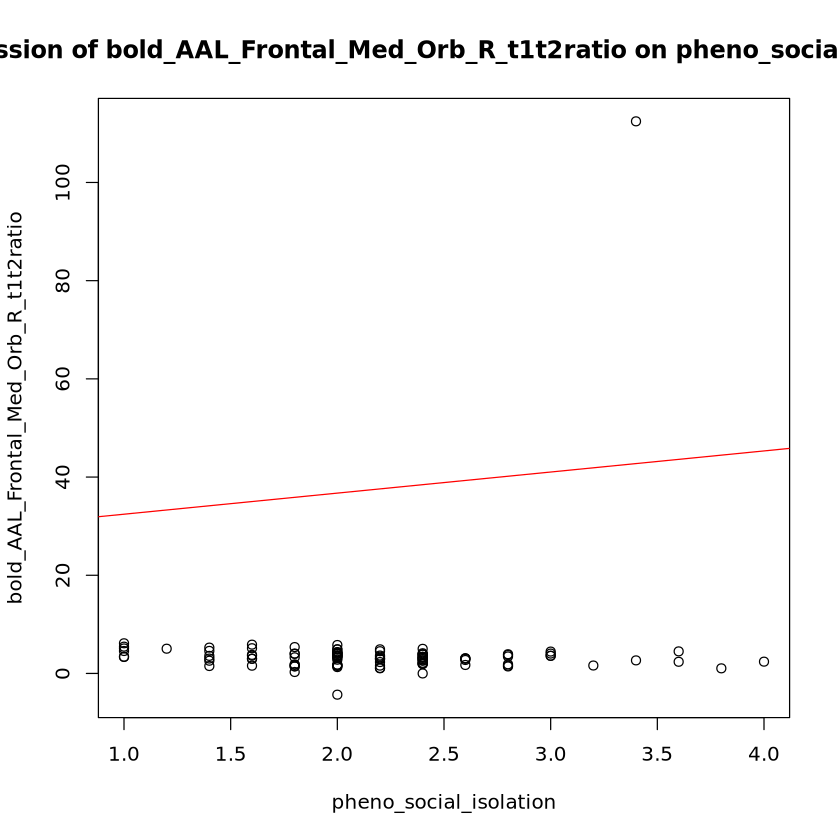

In [11]:
plot(fmri_data_male$pheno_social_isolation, fmri_data_male$bold_AAL_Frontal_Med_Orb_R_t1t2ratio, 
     main = "Regression of bold_AAL_Frontal_Med_Orb_R_t1t2ratio on pheno_social_isolation",
     xlab = "pheno_social_isolation", 
     ylab = "bold_AAL_Frontal_Med_Orb_R_t1t2ratio")
abline(model, col = "red")

`geom_smooth()` using formula = 'y ~ x'


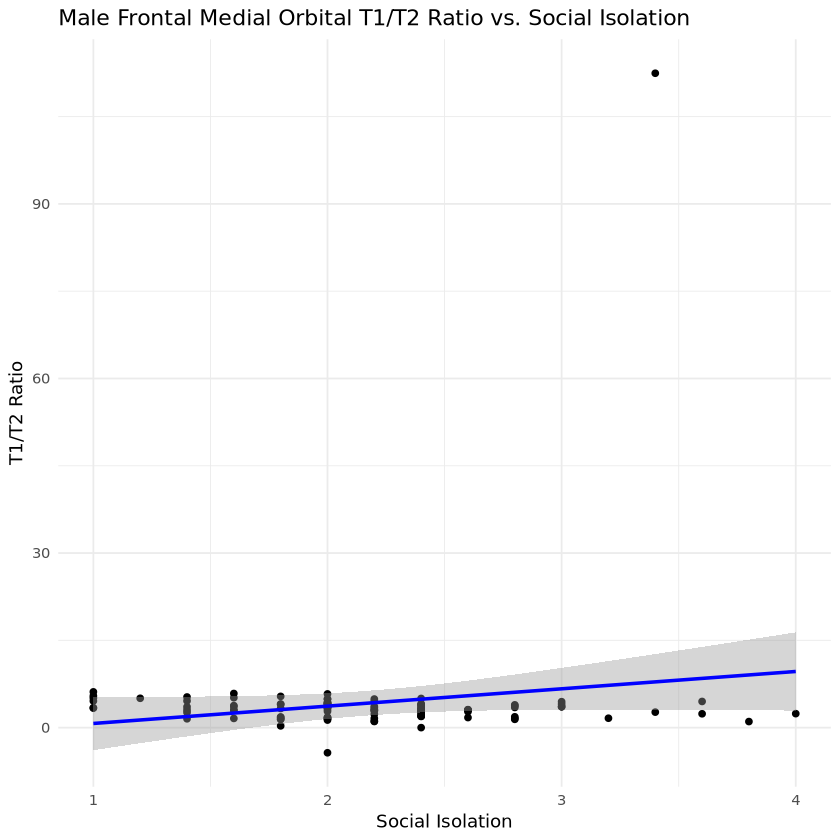

In [15]:
# Plot using ggplot2
ggplot(fmri_data_male, aes(x = pheno_social_isolation, y = bold_AAL_Frontal_Med_Orb_R_t1t2ratio)) +
  geom_point() +  # Add points
  geom_smooth(method = "lm", col = "blue") +  # Add regression line
  labs(title = "Male Frontal Medial Orbital T1/T2 Ratio vs. Social Isolation",
       x = "Social Isolation", 
       y = "T1/T2 Ratio") +
  theme_minimal()


`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 3 rows containing non-finite outside the scale range (`stat_smooth()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range (`geom_point()`).”


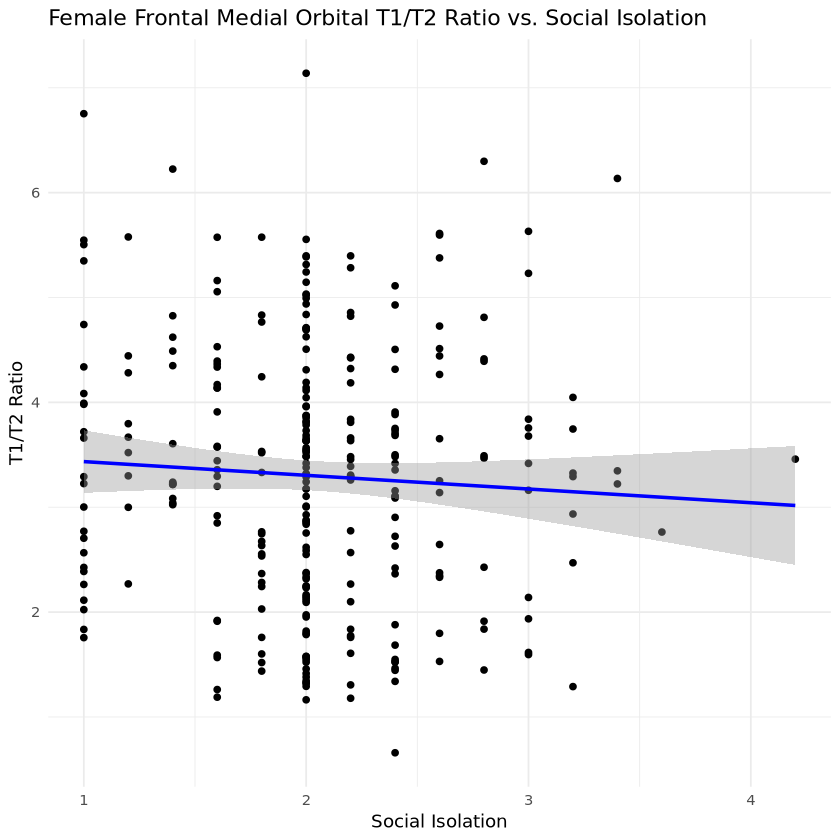

In [16]:
# Plot using ggplot2
ggplot(fmri_data_female, aes(x = pheno_social_isolation, y = bold_AAL_Frontal_Med_Orb_R_t1t2ratio)) +
  geom_point() +  # Add points
  geom_smooth(method = "lm", col = "blue") +  # Add regression line
  labs(title = "Female Frontal Medial Orbital T1/T2 Ratio vs. Social Isolation",
       x = "Social Isolation", 
       y = "T1/T2 Ratio") +
  theme_minimal()


In [17]:
# Subset the data frame based on the threshold
no_outliers_male <- fmri_data_male[fmri_data_male$bold_AAL_Frontal_Med_Orb_R_t1t2ratio < 10, ]

In [19]:
# Subset the data frame based on the threshold
no_outliers_female <- fmri_data_female[fmri_data_female$bold_AAL_Frontal_Med_Orb_R_t1t2ratio < 10, ]

`geom_smooth()` using formula = 'y ~ x'


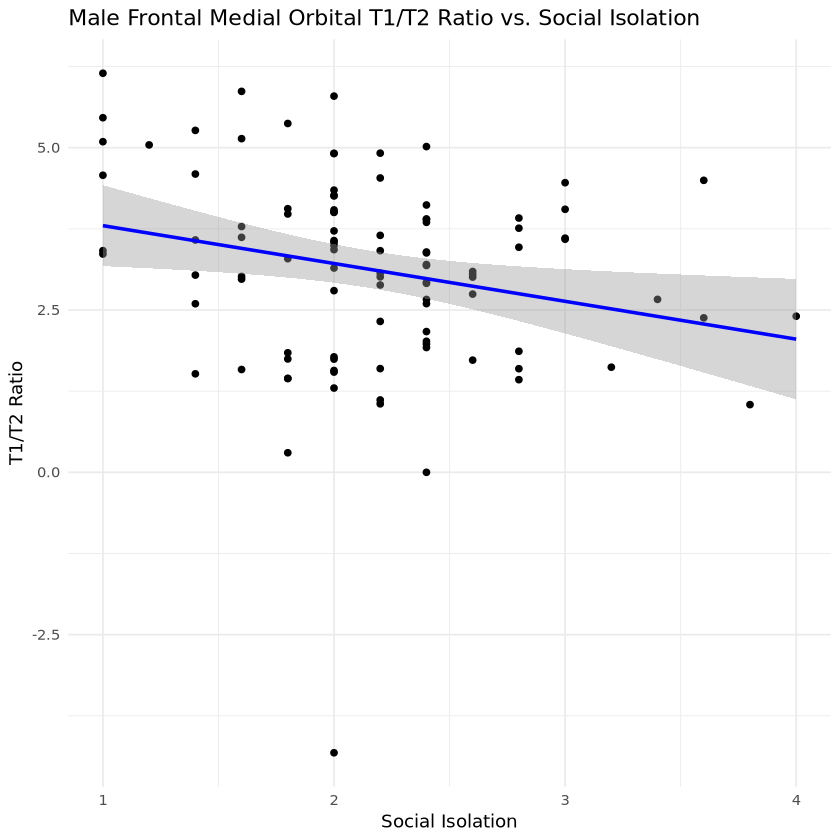

In [18]:
# Plot using ggplot2
ggplot(no_outliers_male, aes(x = pheno_social_isolation, y = bold_AAL_Frontal_Med_Orb_R_t1t2ratio)) +
  geom_point() +  # Add points
  geom_smooth(method = "lm", col = "blue") +  # Add regression line
  labs(title = "Male Frontal Medial Orbital T1/T2 Ratio vs. Social Isolation",
       x = "Social Isolation", 
       y = "T1/T2 Ratio") +
  theme_minimal()


`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 3 rows containing non-finite outside the scale range (`stat_smooth()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range (`geom_point()`).”


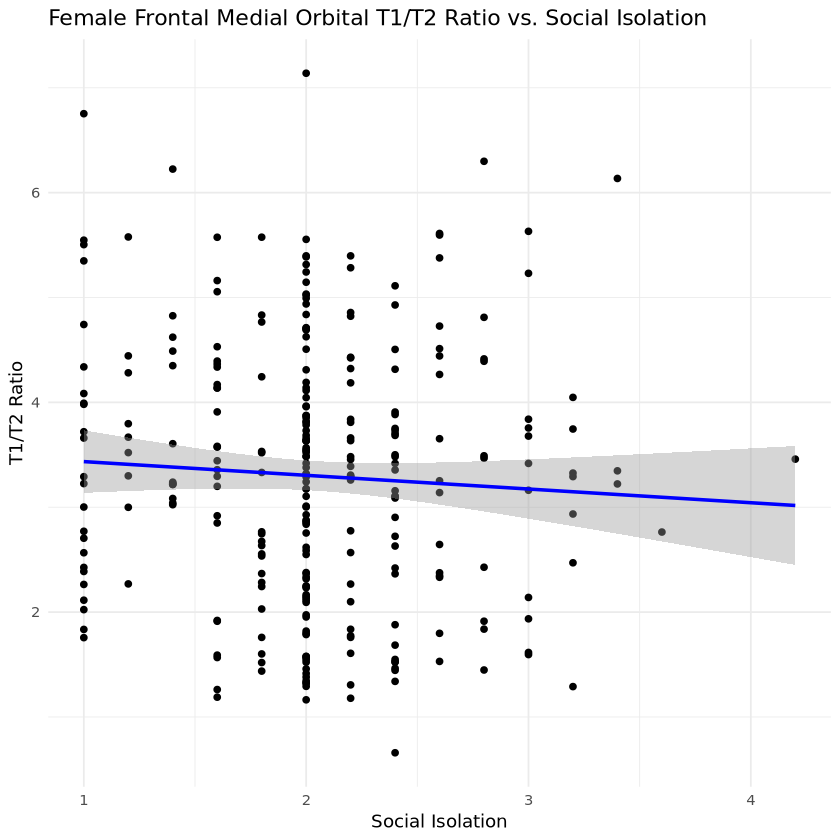

In [20]:
# Plot using ggplot2
ggplot(no_outliers_female, aes(x = pheno_social_isolation, y = bold_AAL_Frontal_Med_Orb_R_t1t2ratio)) +
  geom_point() +  # Add points
  geom_smooth(method = "lm", col = "blue") +  # Add regression line
  labs(title = "Female Frontal Medial Orbital T1/T2 Ratio vs. Social Isolation",
       x = "Social Isolation", 
       y = "T1/T2 Ratio") +
  theme_minimal()

In [26]:
fmri_data_male['bold_AAL_Frontal_Med_Orb_R_t1t2ratio']

,bold_AAL_Frontal_Med_Orb_R_t1t2ratio
,<dbl>
1,3.016433
20,3.037712
29,2.797823
40,5.793920
42,4.346113
44,4.497026
45,4.003023
61,3.413632
68,1.426750


In [27]:
fmri_data_female['bold_AAL_Frontal_Med_Orb_R_t1t2ratio']

,bold_AAL_Frontal_Med_Orb_R_t1t2ratio
,<dbl>
2,1.380575
3,2.316938
4,4.190729
6,3.548432
7,5.283615
8,2.644875
9,5.397075
10,4.414710
13,3.217794


In [28]:
install.packages("modelsummary")

also installing the dependencies ‘bayestestR’, ‘datawizard’, ‘checkmate’, ‘insight’, ‘parameters’, ‘performance’, ‘tables’, ‘tinytable’




In [29]:
model <- lm(bold_AAL_Frontal_Med_Orb_R_t1t2ratio ~ pheno_social_isolation + pheno_age_at_visit, data = no_outliers_male)

In [30]:
library(modelsummary)
modelsummary(model)

`modelsummary` 2.0.0 now uses `tinytable` as its default table-drawing
  backend. Learn more at: https://vincentarelbundock.github.io/tinytable/

Revert to `kableExtra` for one session:

  options(modelsummary_factory_default = 'kableExtra')
  options(modelsummary_factory_latex = 'kableExtra')
  options(modelsummary_factory_html = 'kableExtra')

Silence this message forever:

  config_modelsummary(startup_message = FALSE)




+------------------------+----------+
|                        | (1)      |
+========================+==========+
| (Intercept)            | 7.840    |
+------------------------+----------+
|                        | (1.521)  |
+------------------------+----------+
| pheno_social_isolation | -0.400   |
+------------------------+----------+
|                        | (0.247)  |
+------------------------+----------+
| pheno_age_at_visit     | -0.048   |
+------------------------+----------+
|                        | (0.020)  |
+------------------------+----------+
| Num.Obs.               | 101      |
+------------------------+----------+
| R2                     | 0.109    |
+------------------------+----------+
| R2 Adj.                | 0.091    |
+------------------------+----------+
| AIC                    | 362.8    |
+------------------------+----------+
| BIC                    | 373.3    |
+------------------------+----------+
| Log.Lik.               | -177.412 |
+----------

In [31]:
kableExtra::kable(x = broom::tidy(model), format = "pipe")



|term                   |   estimate| std.error| statistic|   p.value|
|:----------------------|----------:|---------:|---------:|---------:|
|(Intercept)            |  7.8397461| 1.5211207|  5.153928| 0.0000013|
|pheno_social_isolation | -0.3999190| 0.2472145| -1.617700| 0.1089416|
|pheno_age_at_visit     | -0.0476333| 0.0196553| -2.423432| 0.0172094|

In [34]:
install.packages("webshot2")

also installing the dependencies ‘AsioHeaders’, ‘websocket’, ‘chromote’




In [32]:
# Install phantomjs if it's not already installed
webshot::install_phantomjs()

# Fit a model (for example purposes)
model <- lm(mpg ~ cyl + hp, data = mtcars)

# Create the table using kableExtra
table_html <- kableExtra::kable(x = broom::tidy(model), format = "html") %>%
  kable_styling(bootstrap_options = "striped", full_width = F)

# Save the table as an HTML file
save_kable(table_html, "table.html")

# Convert the HTML to a PNG using webshot
webshot2::webshot("table.html", file = "table.png")

ERROR: Error in loadNamespace(x): there is no package called ‘webshot’
